# **Desafio Cientista de Dados - Indicium LightHouse**

**Tópicos neste notebook:**

4 - EDA (Análise Exploratória de Dados)

5 - Respostas das Perguntas de Negócio solicitadas no desafio



# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from plotly         import express as px
from nltk.corpus    import stopwords
from unicodedata    import normalize

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

## 0.1 Helper Function

In [2]:
# Cramers V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


# Configurações Gerais
# pd.set_option('display.max_rows', None)
# pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [25, 12]

-----

# **4.0 EDA (Exploratory Data Analysis)**

A Análise Exploratória de Dados (EDA) é a etapa inicial na análise de dados, é essencial para compreender a estrutura dos dados, detectar anomalias, identificar variáveis relevantes, verificar hipóteses e gerar insights valiosos para o negócio.

Obs.: 

- A estatística descritiva dos dados foi feita na tópico 1.8.

- Em alguns momentos desconsiderei os outliers/valores atípicos para melhorar a visualização


In [3]:
# Reading dataset
df4 = pd.read_csv('../datasets/cooked_datasets/df3_processed.csv', low_memory = False)

# Mudando tipo para data
df4['ultima_review'] = pd.to_datetime(df4['ultima_review'])

## **4.1 Análise Univariada**

Na análise univariada, examinamos uma única variável por vez para entender sua distribuição e características individuais. Isso nos ajuda a descrever as propriedades fundamentais de cada variável e identificar padrões ou anomalias dentro delas.

In [4]:
# Separando variáveis numéricas e categóricas 
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 4.1.1 Variável Target

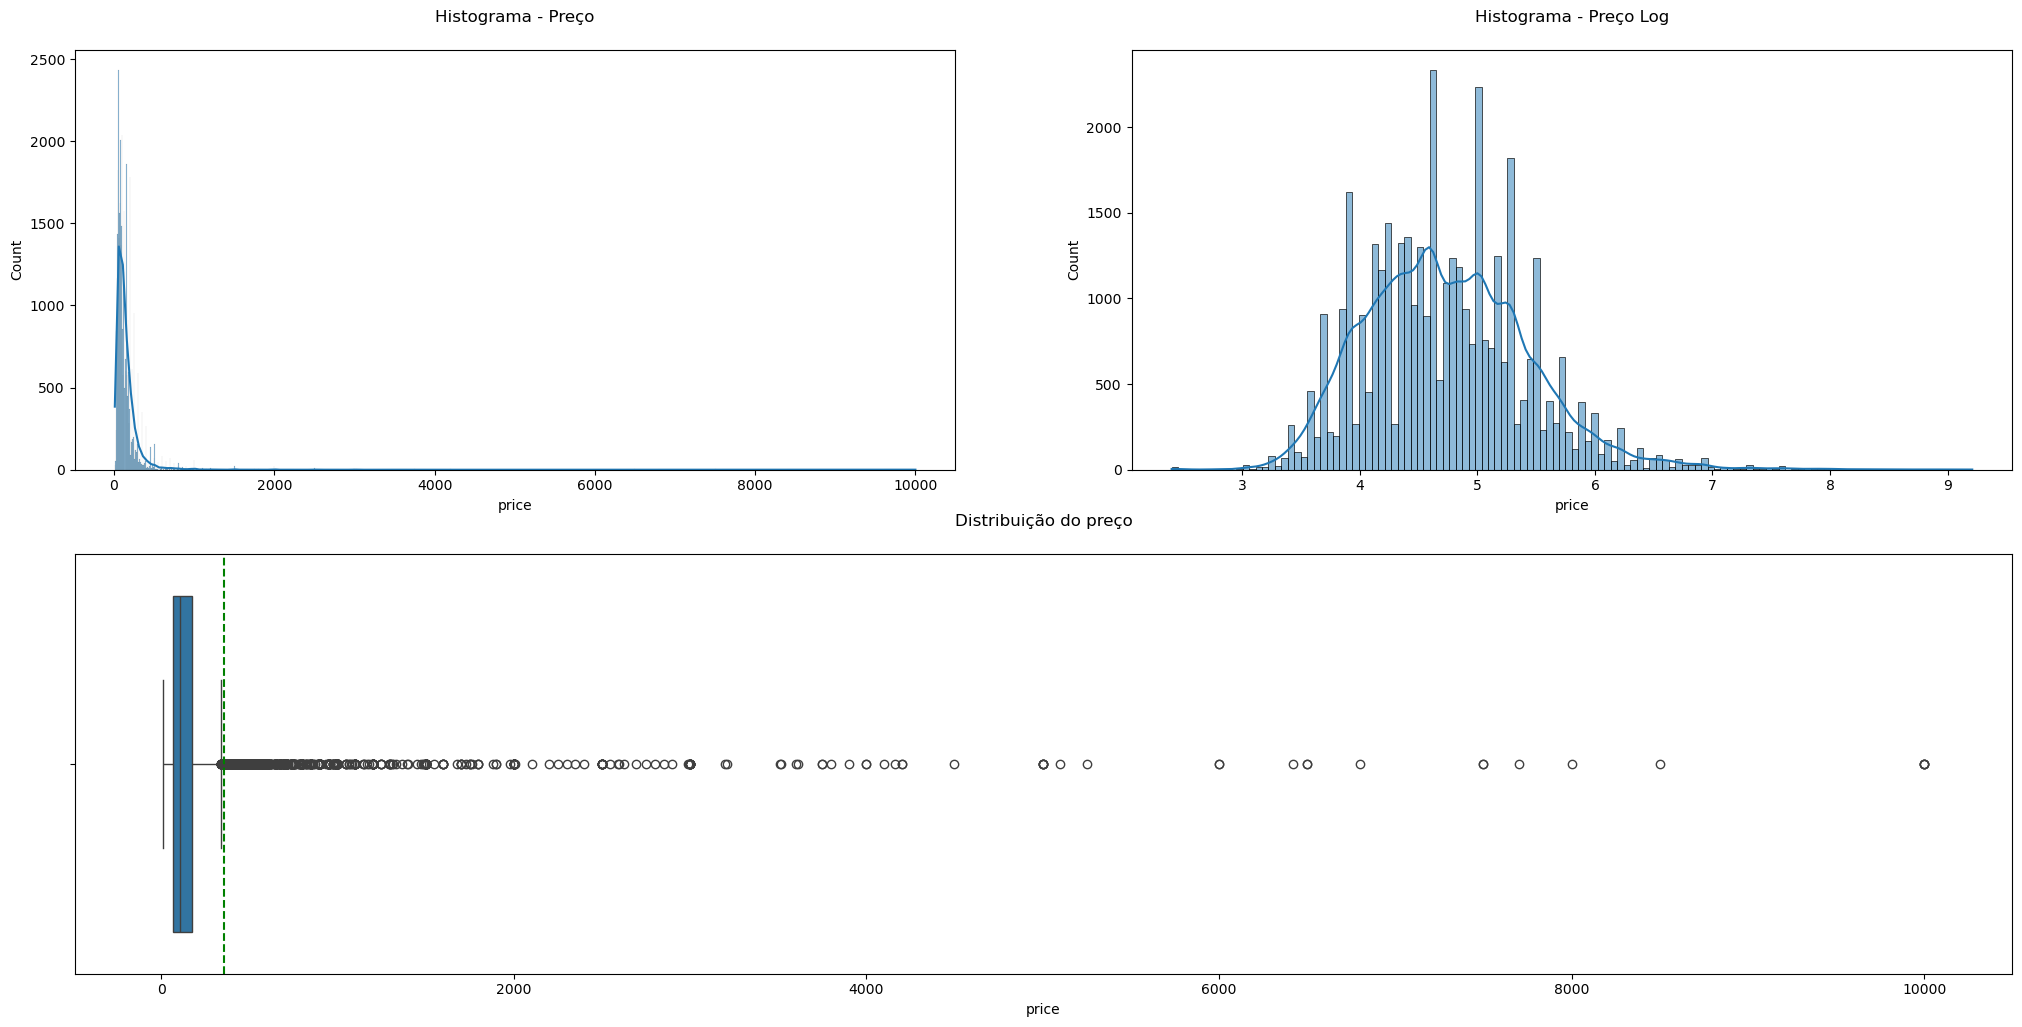

In [5]:
# Histograma coluna 'price'
plt.subplot(2,2,1)
sns.histplot(df4['price'], kde=True);
plt.title('Histograma - Preço', pad=20)

# Histograma coluna 'log_price'
plt.subplot(2, 2, 2)
log_price = np.log1p(df4['price'])
sns.histplot(log_price, kde=True)
plt.title('Histograma - Preço Log', pad=20)

# Boxplotcoluna 'price'
plt.subplot(2, 1, 2)
sns.boxplot(data=df4['price'], orient='h')
plt.title('Distribuição do preço', pad=20)
plt.axvline(x=358, color='g', linestyle='--', label='$300')
plt.show()

É fundamental verificar se a variável alvo (target/variável dependente/variável resposta), que estamos tentando prever, se aproxime de uma distribuição normal/gaussiana após a aplicação do log como um recurso matemático. Isso é importante porque os algoritmos de machine learning apresentam um melhor desempenho quando as suposições para as quais foram desenvolvidos são atendidas, e uma dessas premissas é que a curva da variável alvo se assemelhe a uma distribuição normal. Depois da aplicação do machine learning, podemos reverter os valores dessa coluna utilizando a função exponencial, o que nos permite interpretar e comunicar de maneira mais clara a performance do modelo.

### 4.1.2 Variáveis Numéricas

<Figure size 2000x1500 with 0 Axes>

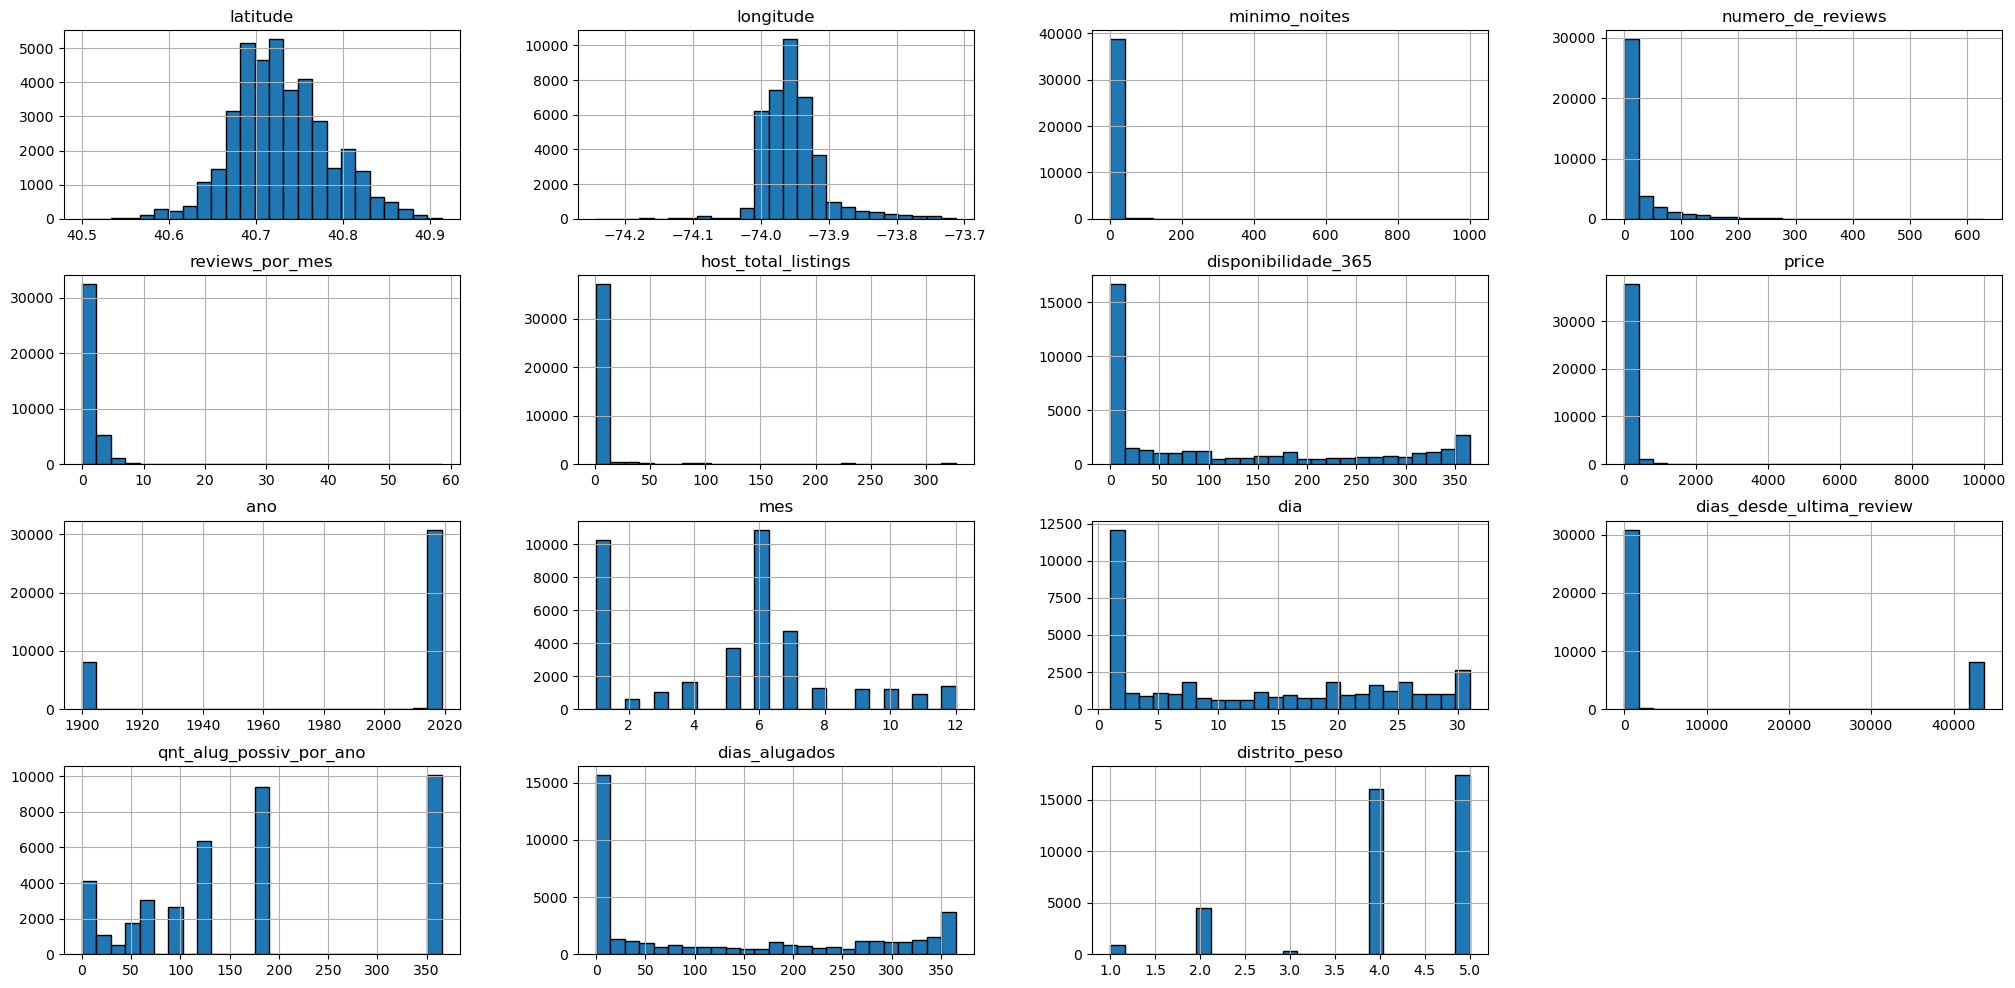

In [6]:
plt.figure(figsize=(20,15))
aux = num_attributes.drop(['id', 'host_id'], axis=1)
aux.hist(bins=25, edgecolor='black');

É importante observar que variáveis com uma variedade de picos e vales são importantes. Quanto mais variabilidade elas exibem, mais explicativas tendem a ser em relação ao fenômeno em questão. Essa diversidade de comportamentos pode fornecer insights valiosos e uma compreensão mais profunda do conjunto de dados ou do fenômeno que está sendo analisado.

### 4.1.3 Variáveis Categóricas

#### Coluna distrito

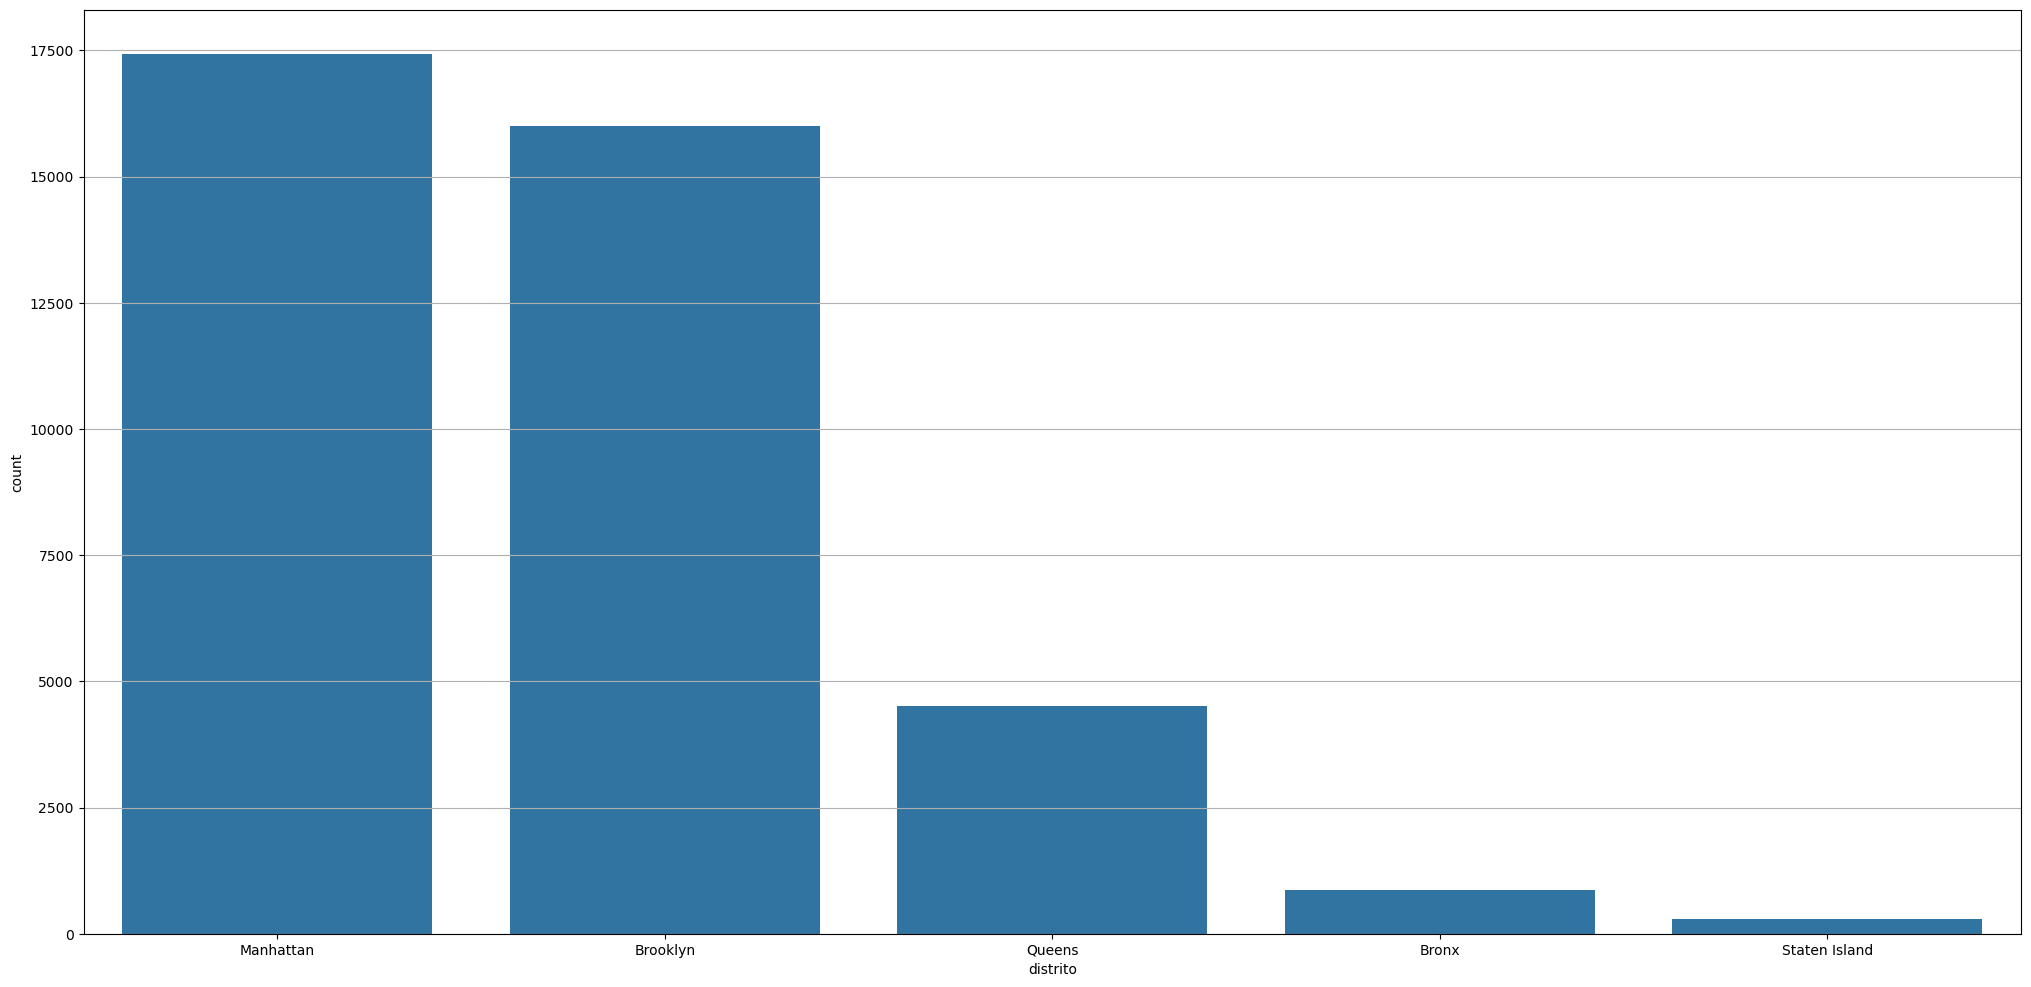

In [7]:
# Coluna distrito
order=cat_attributes['distrito'].value_counts().index
ax = sns.countplot(data=cat_attributes, x='distrito', order=order)
ax.grid(axis='y')

Como visto anteriormente, o bairro de Manhattan e Broklyn possuem a maior parte dos imóveis do dataset, mas com uma diferença entre eles de 1427 imóveis.

-----

#### Coluna bairro

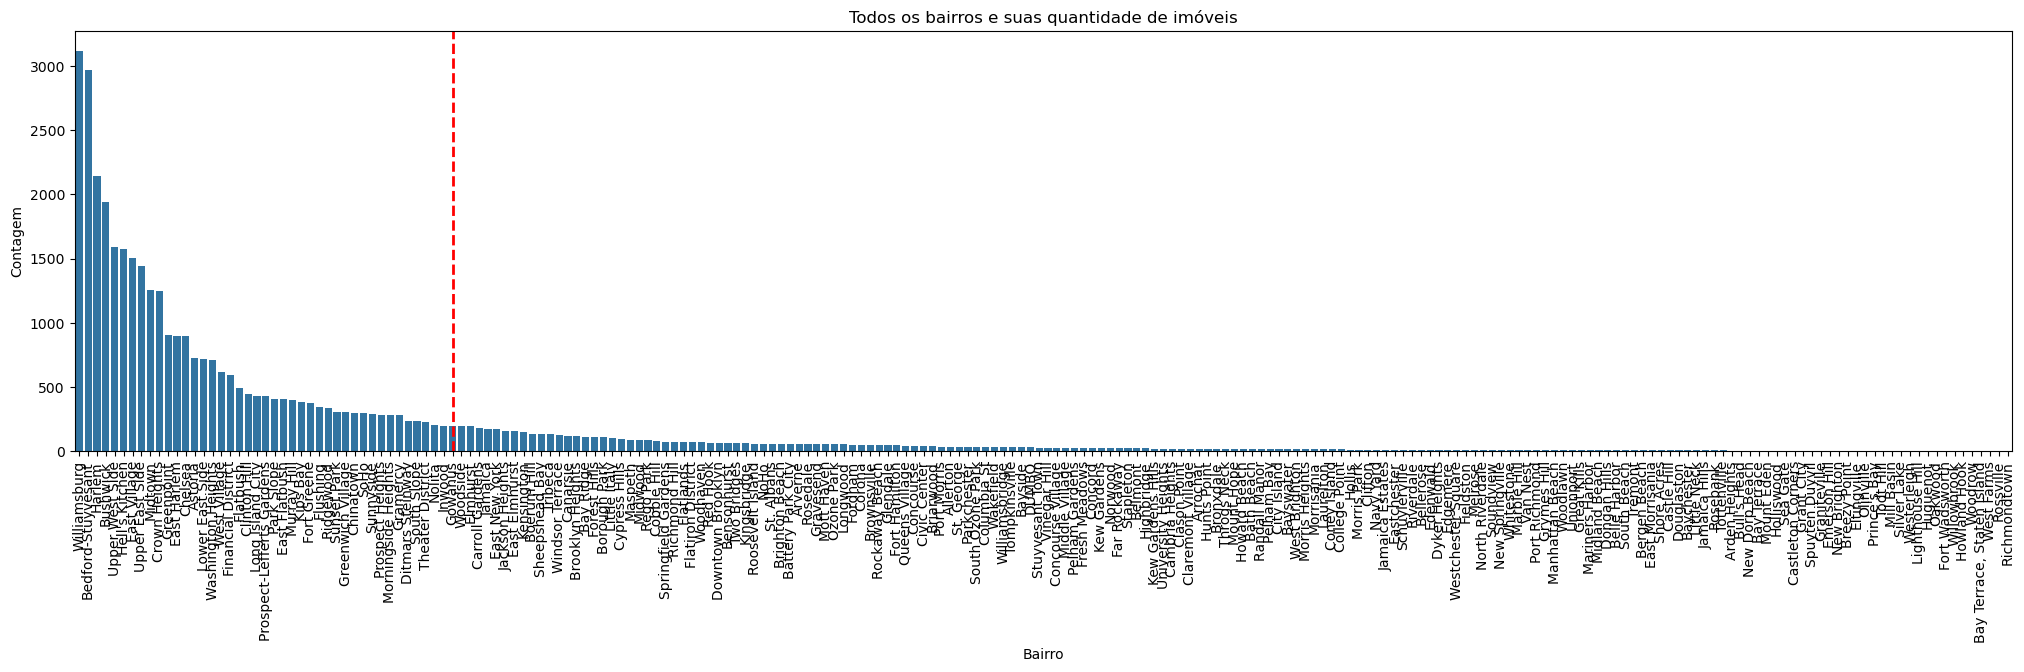

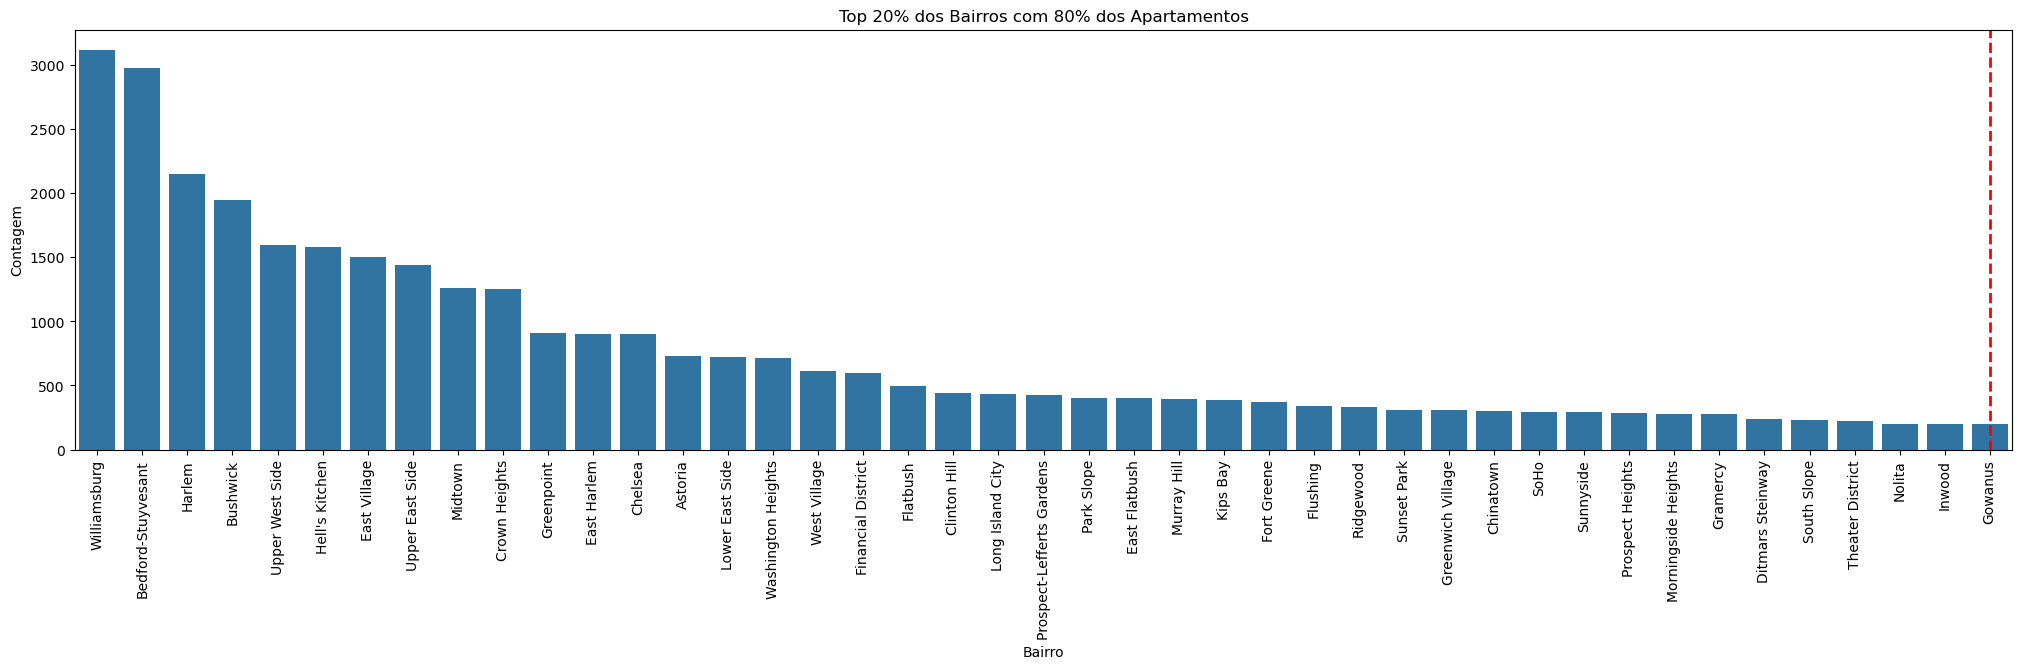

In [8]:
# Plot coluna bairro - Visualização de todos os bairros
plt.subplot(2,1,1)
order=cat_attributes['bairro'].value_counts().index
sns.countplot(data=cat_attributes, x='bairro', order=order)
indice_gowanus = cat_attributes['bairro'].value_counts().index.get_loc('Gowanus')
plt.axvline(x=indice_gowanus, color='red', linestyle='--', linewidth=2)
plt.xticks(rotation=90)
plt.title('Todos os bairros e suas quantidade de imóveis')
plt.xlabel('Bairro')
plt.ylabel('Contagem')
plt.show()

# plt.subplot(2,1,2)
# order=cat_attributes['bairro'].value_counts().head(20).index
# sns.countplot(data=cat_attributes, x='bairro', order=order)
# plt.xticks(rotation=90)
# plt.show()

# Plot coluna bairro pareto 80/20
# Contar os bairros
contagem_bairros = cat_attributes['bairro'].value_counts()

# Quantidade de bairros que representam 20% dos bairros
bairro20p = math.floor(len(contagem_bairros) * 0.2)

# Obter os bairros que representam os 20% superiores em termos de contagem
bairros_top_20 = contagem_bairros.head(bairro20p).index

# Filtrar os dados apenas para os bairros do top 20%
cat_attributes_top_20 = cat_attributes[cat_attributes['bairro'].isin(bairros_top_20)]

plt.subplot(2,1,2)
sns.countplot(data=cat_attributes_top_20, x='bairro', order=bairros_top_20)
plt.xticks(rotation=90)
indice_gowanus = cat_attributes['bairro'].value_counts().index.get_loc('Gowanus')
plt.axvline(x=indice_gowanus, color='red', linestyle='--', linewidth=2)
plt.title('Top 20% dos Bairros com 80% dos Apartamentos')
plt.xlabel('Bairro')
plt.ylabel('Contagem')
plt.show()

Para melhorar a visualização do primeiro gráfico relacionado da coluna bairro, devido a seu grande volume de valores distintos, utilizei o princípio de Pareto para melhorar a visualização, gerando o segundo gráfico onde está plotado 20% dos bairros que contém 80% dos imóveis.

A linha vermelha tracejada apenas facilita a localização/visualização do corte 80/20.

-----

#### Coluna room_type

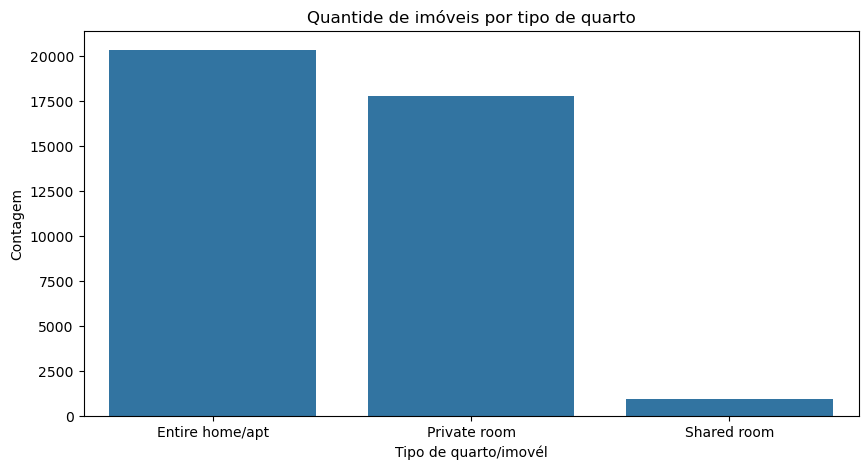

In [9]:
plt.figure(figsize=(10,5))
order=cat_attributes['room_type'].value_counts().index
sns.countplot(data=cat_attributes, x='room_type', order=order)
plt.title('Quantide de imóveis por tipo de quarto')
plt.xlabel('Tipo de quarto/imovél')
plt.ylabel('Contagem')
plt.show()

Como visto anteriormente, o tipo de quarto/sala 'Entire home' e 'Private room' possuem a maior parte dos imóveis do dataset, mas com uma diferença entre eles de 2567 imóveis.

O tipo 'shared room' possui apenas 946 imóveis, representando apenas 2% do dataset.

Também encontrei mais informações sobre o negócio, referente aos tipos de quartos. Fonte:

https://www.airbnb.com.br/help/article/317?_set_bev_on_new_domain=1708121346_NmQxYTViNTI1ZTkx#:~:text=Entire%20place,floor%20of%20the%20home


-----

#### Coluna host_names

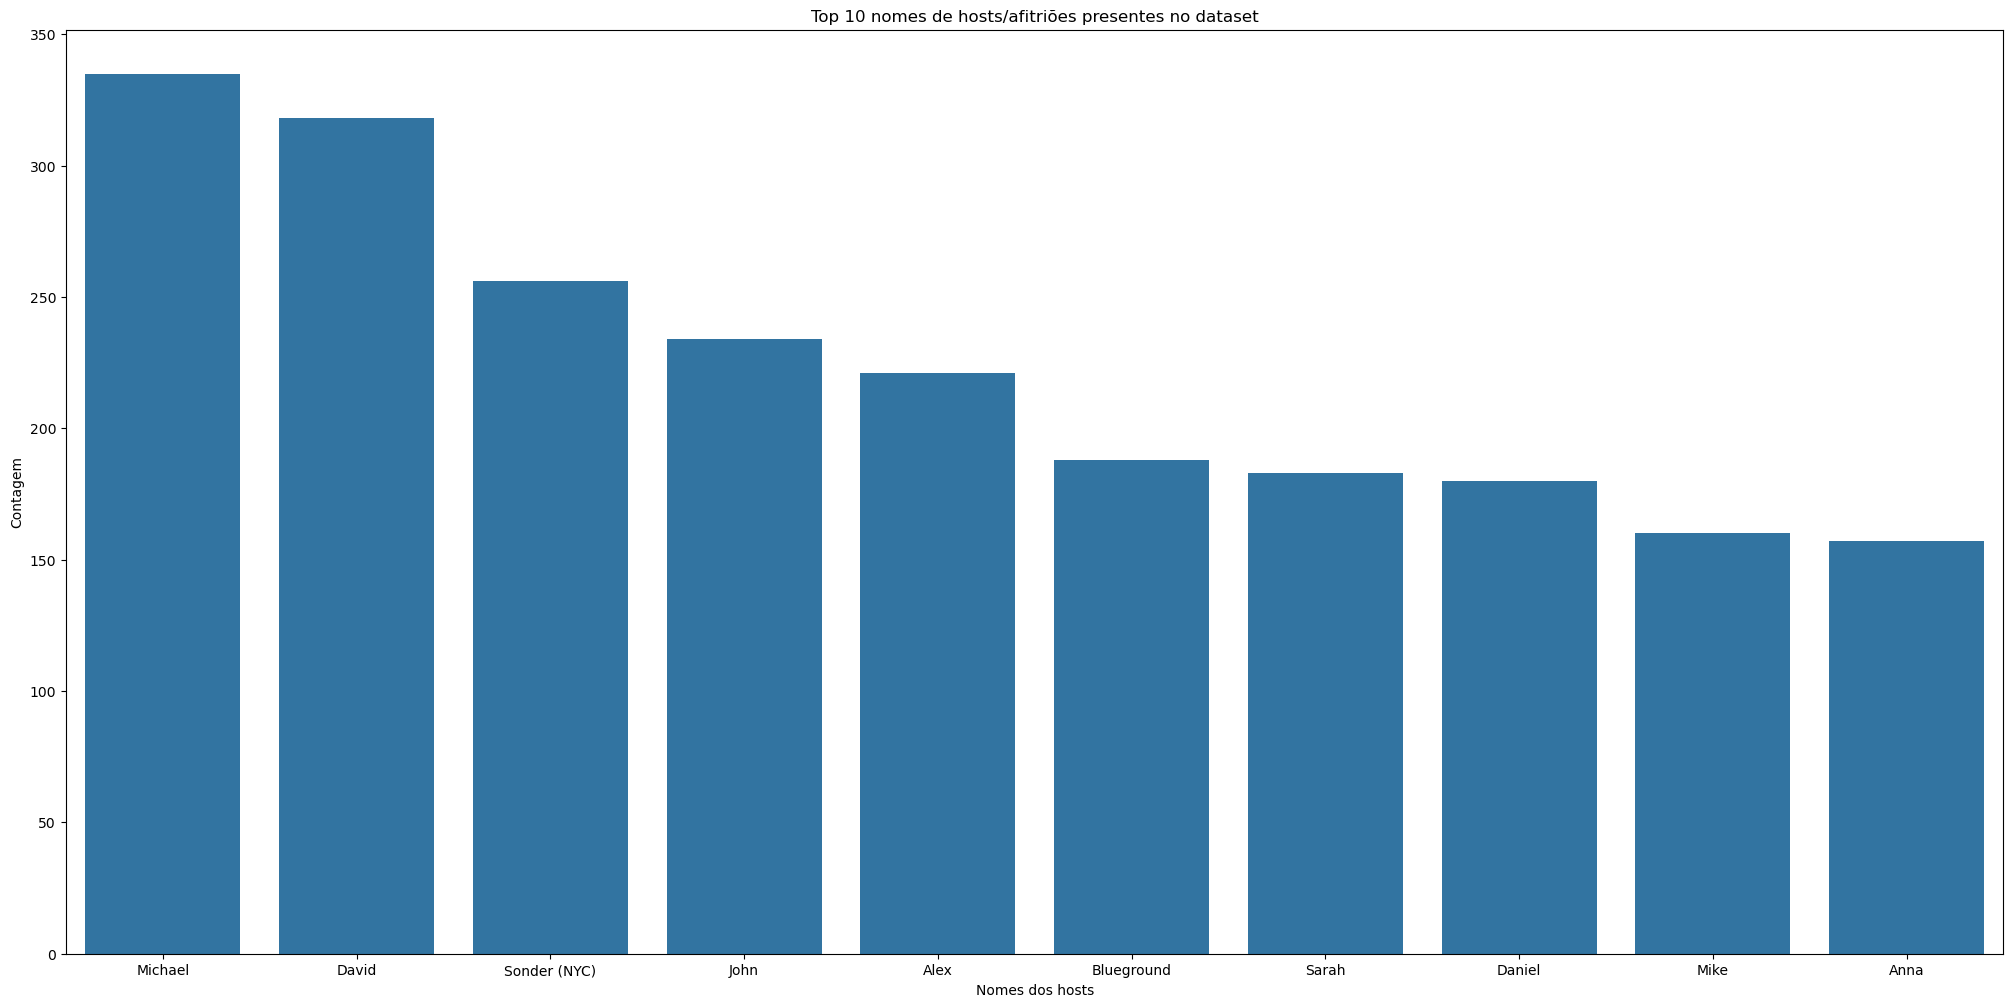

In [10]:
# Plotando top 10 nomes mais presentes no dataset
order=cat_attributes['host_name'].value_counts().head(10).index
sns.countplot(data=cat_attributes, x='host_name', order=order)
plt.title('Top 10 nomes de hosts/afitriões presentes no dataset')
plt.xlabel('Nomes dos hosts')
plt.ylabel('Contagem')
plt.show()

Há 10029 nomes únicos no dataset, o plote acima representa apenas os top 10 nomes mais presentes, adotei essa medida, pois aplicação de pareto seria inviável já que teria 2000 nomes (20%) para o plot.

Observei que dois nomes dentre os top10, são de empresas, a Sonder (NYC) e a Blueground, ou seja, elas possuem uma quantidade considerável de imóveis para aluguel em New York, neste dataset.

Nota-se também que hosts masculinos possuem a maior parcela dentre os top 10 e, sendo Michael, David e John, os nomes mais comuns.

#### Coluna nome (do anúncio)

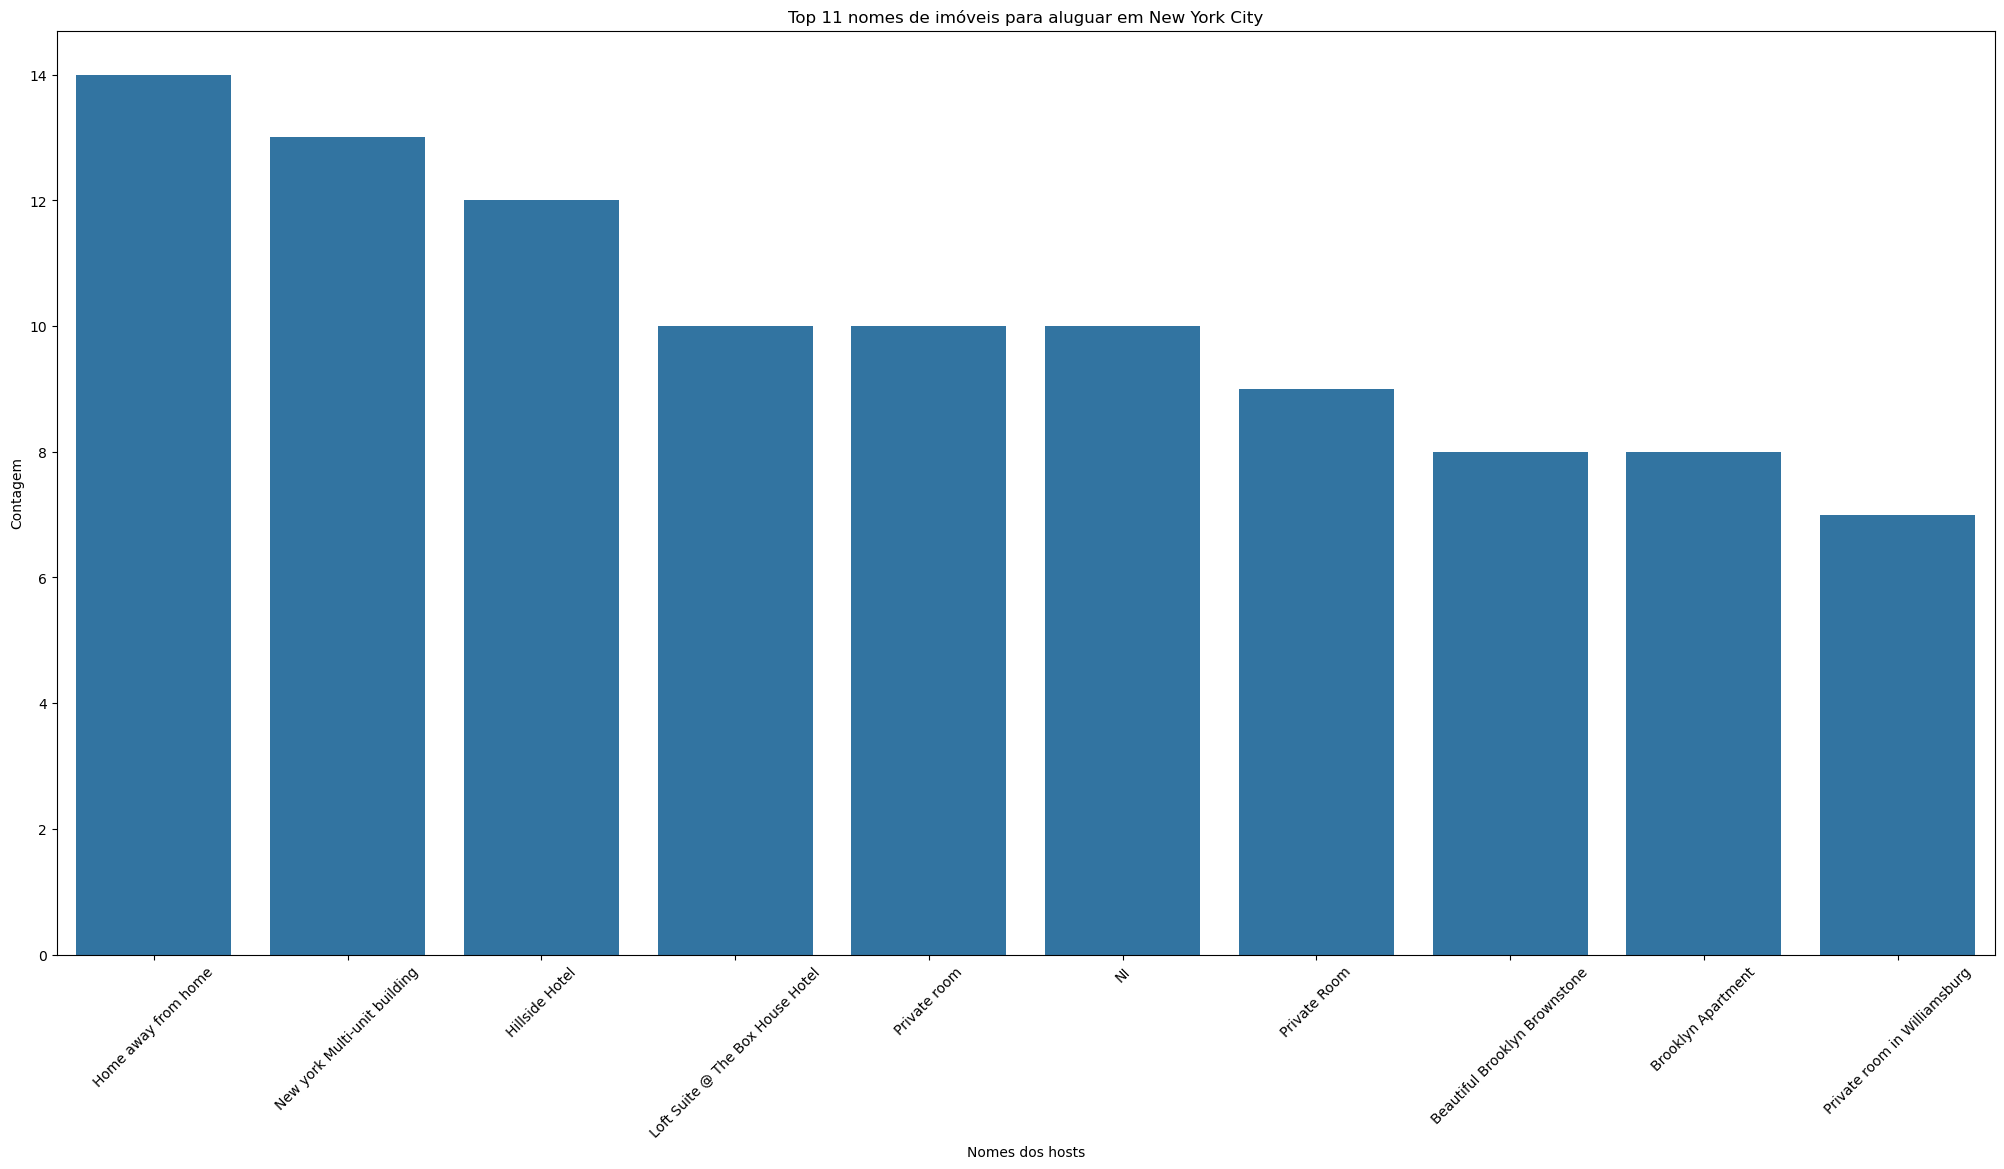

In [11]:
# Plotando top 11 nomes de imóveis para aluguel
order=cat_attributes['nome'].value_counts().head(10).index
sns.countplot(data=cat_attributes, x='nome', order=order)
plt.title('Top 11 nomes de imóveis para aluguar em New York City')
plt.xlabel('Nomes dos hosts')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

Esses são os top 11 nomes que mais se repetiram, irei investigar nas próximas análises e nas próximas perguntas de negócio para identificar algum padrão nos nomes e suas relações.

## **4.2 Análise Bivariada**

Na análise bivariada, exploramos a relação entre duas variáveis, neste caso, a relação que cada variável indepentente tem com a dependente (target). Isso nos permite entender como as variáveis se relacionam entre si e se existe alguma associação ou correlação significativa entre elas. Nesta etapa, que validamos hipóteses e geramos insights valiosos para o negócio.

### **Lista de Hipóteses a serem validadas**

**1.** Aluguéis de espaço inteiro ('Entire home/apt') possuem preços maiores.

**2.** Imóveis com maiores disponibilidade em dias, possuem preços menores.

**3.**  Um 'mínimo de noites' para reserva de 1 dia, possui preços menores dentre os mínimos 7, 15 e 30 dias.

**4.** Imóveis com mais reviews, possuem preços menores.

**5.** Imóveis com as maiores reviews por mês, possuem preços menores.

**6.** Aluguéis em Manhattan possuem o maior preço dentre os distritos de New York.

**7.** Imóveis com localização próxima ao mar, possuem preços mais caros.

**8.** Hosts que possuem mais imóveis, possuem um preço maior.

### **H1. Aluguéis de espaço inteiro ('Entire home/apt') possuem preços maiores.**
**True** - Aluguéis de espaço inteiro ('Entire home/apt') possuem preços maiores.

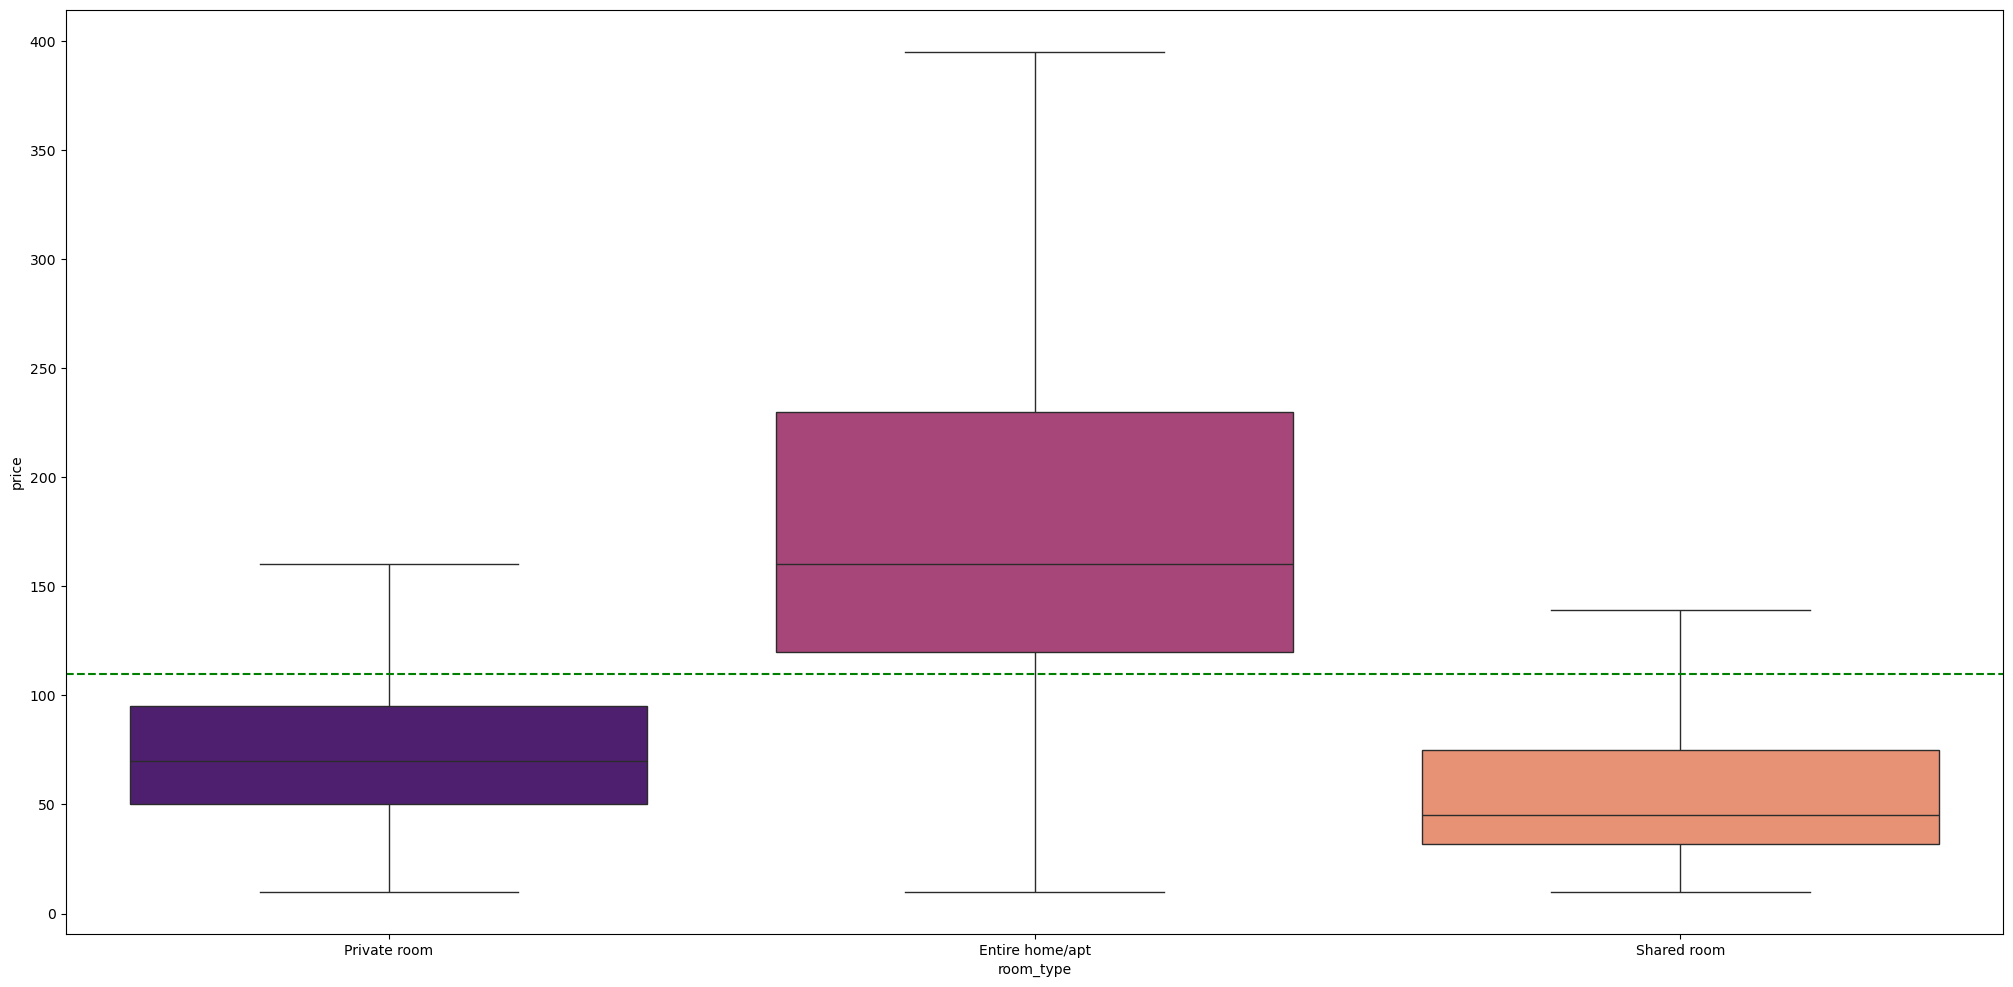

In [12]:
sns.boxplot(data=df4, x='room_type', y='price', palette='magma', showfliers=False)
plt.axhline(y=110, linestyle='--', color='green')

É nítido no boxplot acima, que a 'Entire home/apt' possui preços maiores que as demais categorias porque 75% dos seus valores são maiores que 75% do valores de 'Private room' e 'Shared room'.

### **H2. Imóveis com maiores disponibilidade em dias, possuem preços menores.**
**False** - Há vários valores de preço em todos os valores de disponibilidade.

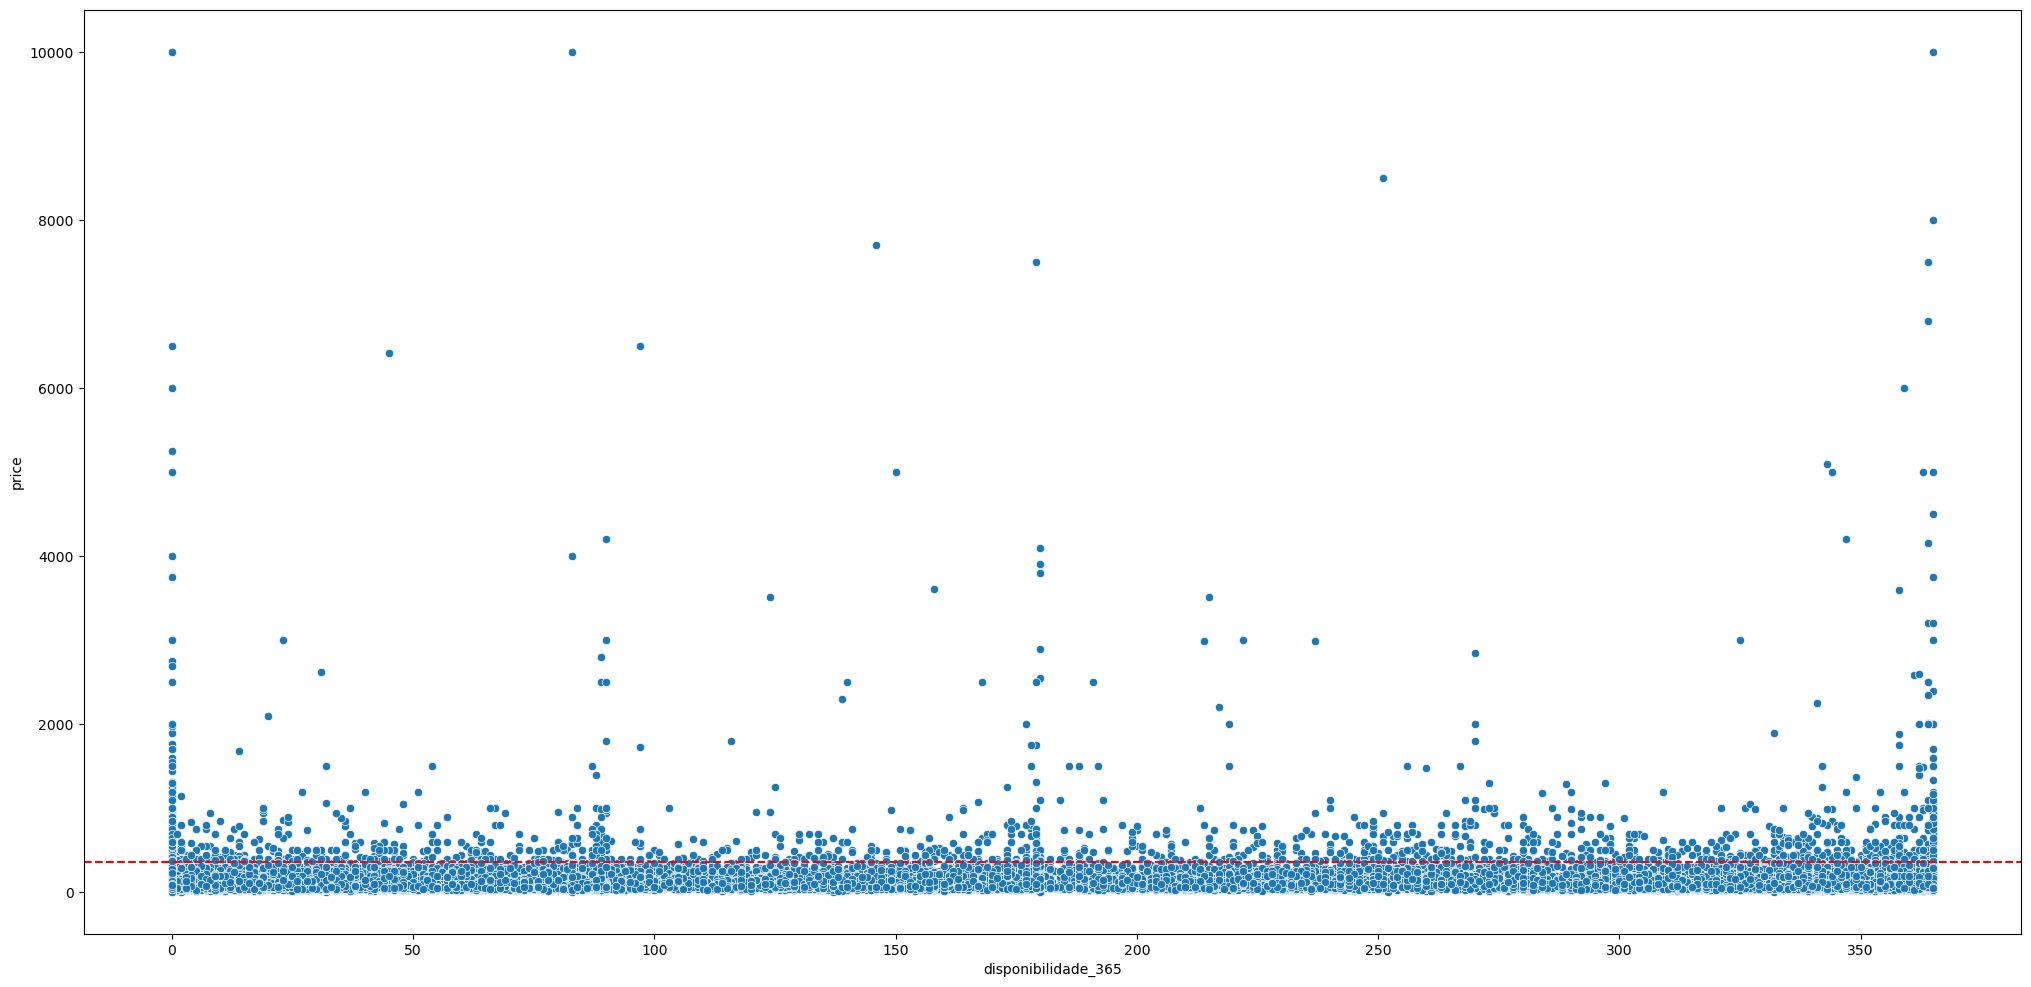

In [13]:
sns.scatterplot(data=df4, x='disponibilidade_365', y='price')
plt.axhline(y=360, linestyle='--', color='red')

Não vejo um padrão entre a disponibilidade aumentar ou abaixar que influencie nos preços, o que podemos ver são outliers/valores atípicos que possuem preços elevados, mas mesmo assim estão presentes desde 0 dias até o valor máximo no fim do eixo x (disponibilidade em dias). 

Na análise multivariada também investigo a correlação entre elas, mas adianto que a correlação é muito fraca quase nula.

### **H3. Um 'mínimo de noites' para reserva de 1 dia, possui preços menores dentre os mínimos 7, 15 e 30 dias.**
**False** - Um 'mínimo de noites' de 15 dias é que possui os preços menores.

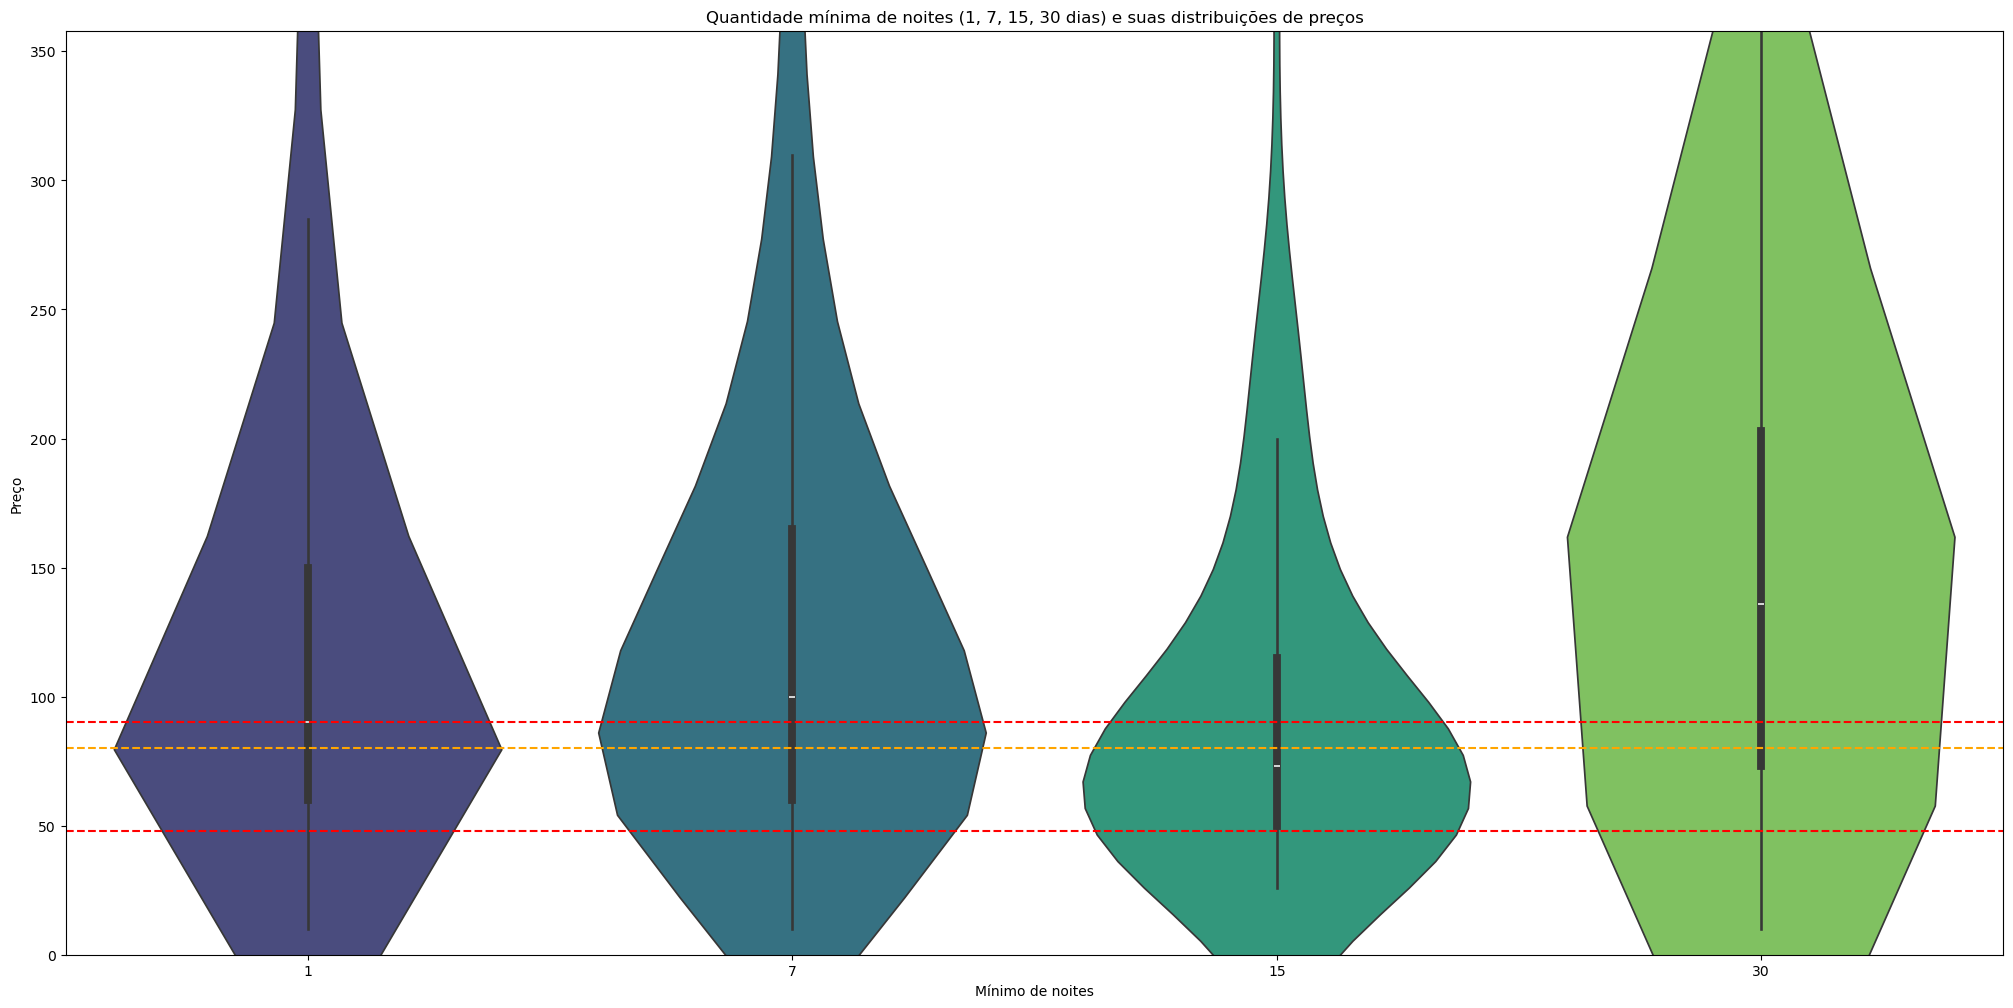

In [14]:
# Selecionando dias desejados
aux = df4[df4['minimo_noites'].isin([1, 7, 15, 30])]

# Plot 
sns.violinplot(data=aux, x='minimo_noites', y='price', color='blue', palette='viridis')
plt.axhline(y=90, linestyle='--', color='red')
plt.axhline(y=80, linestyle='--', color='orange')
plt.axhline(y=48, linestyle='--', color='red')
plt.ylim(0, 358)
plt.title('Quantidade mínima de noites (1, 7, 15, 30 dias) e suas distribuições de preços')
plt.xlabel('Mínimo de noites')
plt.ylabel('Preço')
plt.show()

Observo que: 

A mediana do dia 15 está abaixo da mediana do dia 1 e;

A maior densidade do dia 1, está acima da mediana do dia 15;

O dia 15 possui a menor mediana e o menor intervalo de distribuição.

Logo: Um 'mínimo de noites' de 15 dias é que possui os preços menores.

### **H4. Imóveis com mais reviews, possuem preços menores.**
**True** - Imóveis com mais reviews, possuem preços menores.

<Axes: xlabel='numero_de_reviews', ylabel='price'>

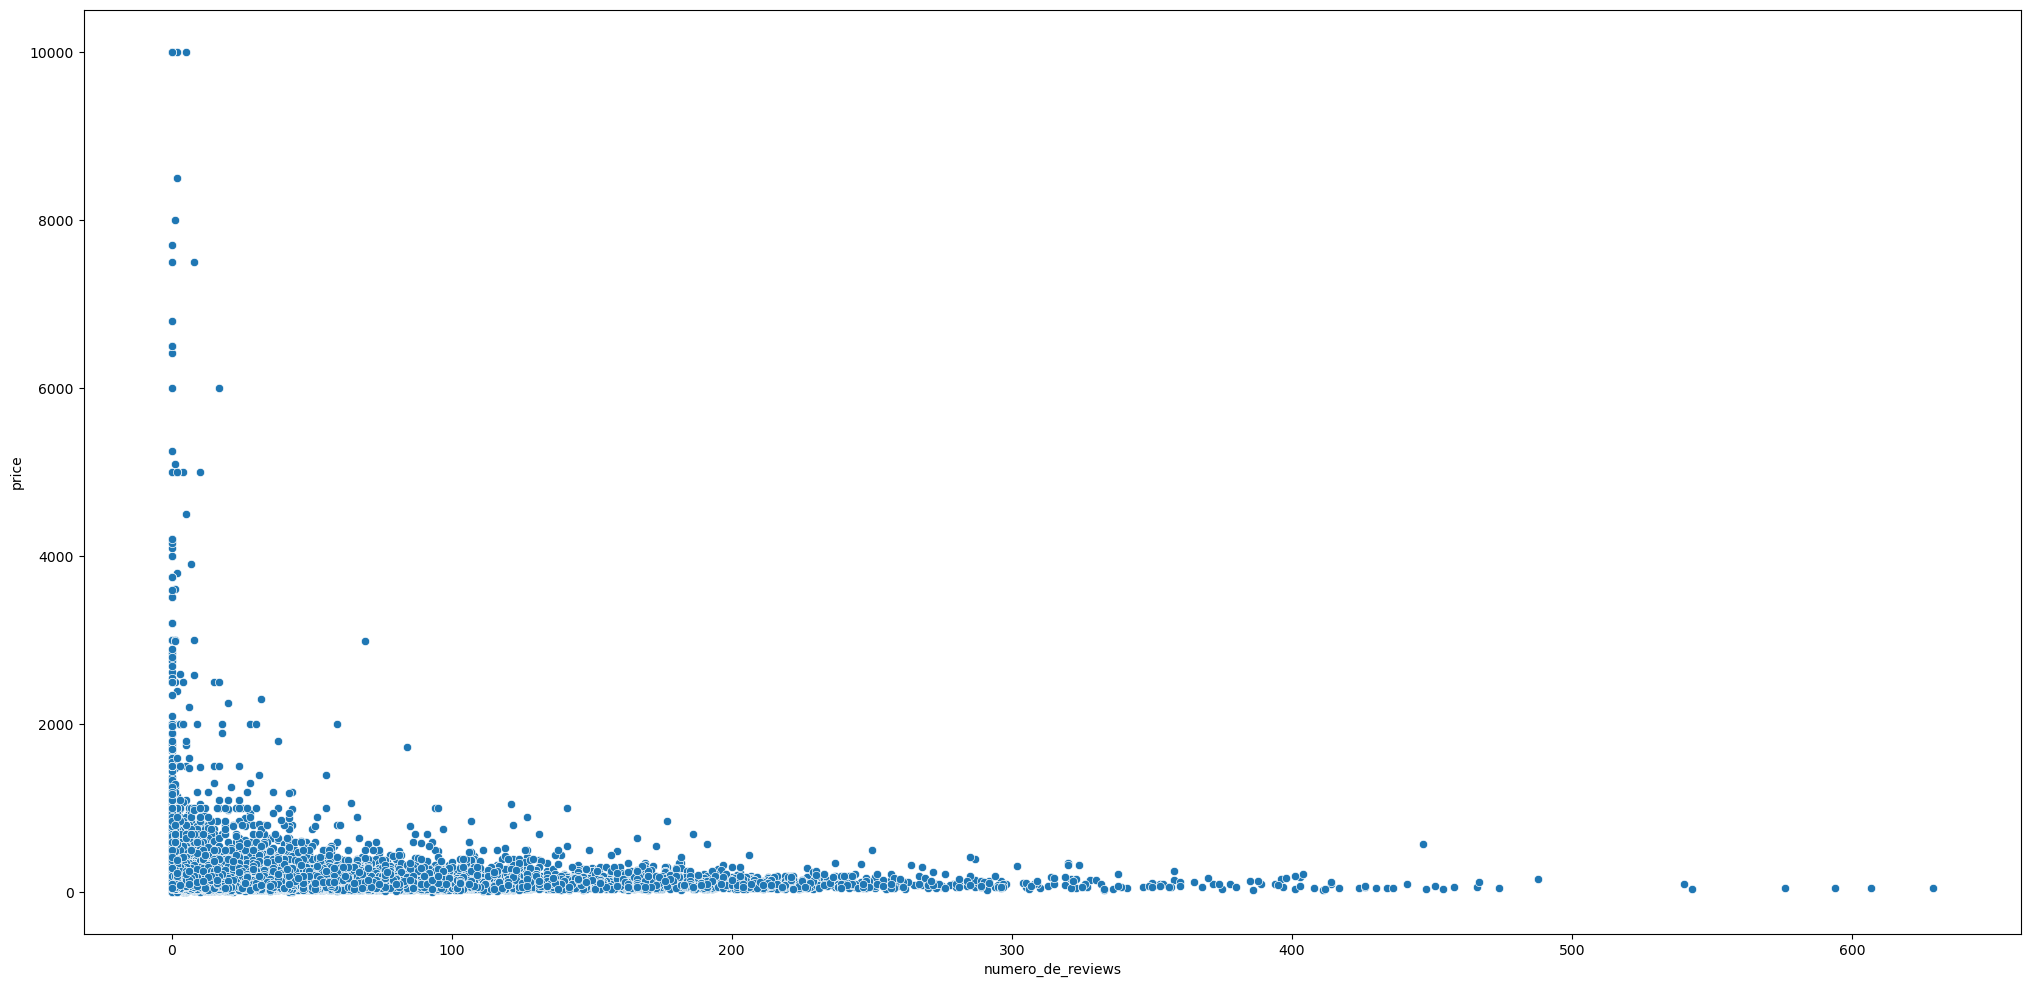

In [15]:
sns.scatterplot(data=df4, x='numero_de_reviews', y='price')

Podemos ver no gráfico acima que, quanto maior a quantidade de reviews, menor o preço do aluguel.

Talvez isso ocorra devido ao baixo preço de aluguel, mais pessoas conseguem pagar, logo, mais reviews.

### **H5. Imóveis com as maiores reviews por mês, possuem preços menores.**
**True** - Imóveis com as maiores reviews por mês, possuem preços menores.

<Axes: xlabel='reviews_por_mes', ylabel='price'>

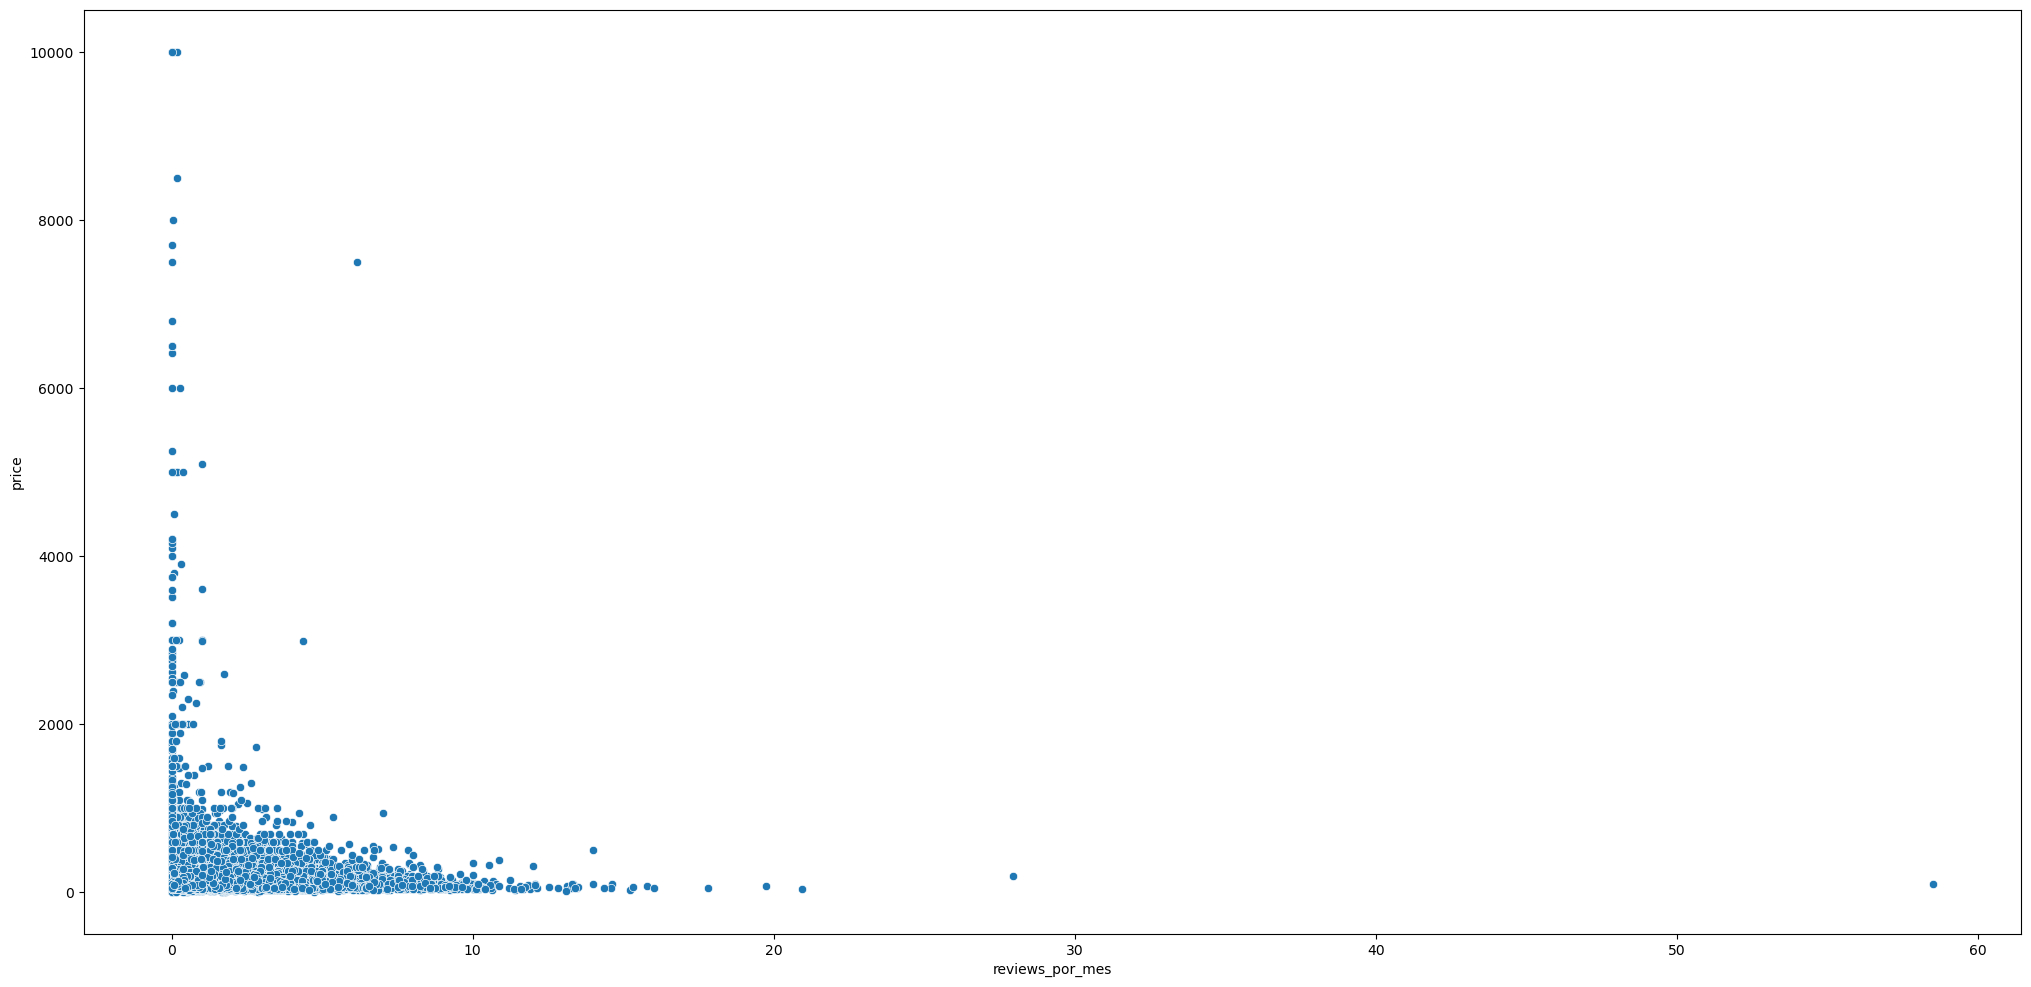

In [16]:
sns.scatterplot(data=df4, x='reviews_por_mes', y='price')

Segue o mesmo raciocínio da hipótese anterior.

### **H6. Aluguéis em Manhattan possuem o maior preço dentre os distritos de New York.**
**True** - Aluguéis em Manhattan possuem o maior preço dentre os distritos de New York.

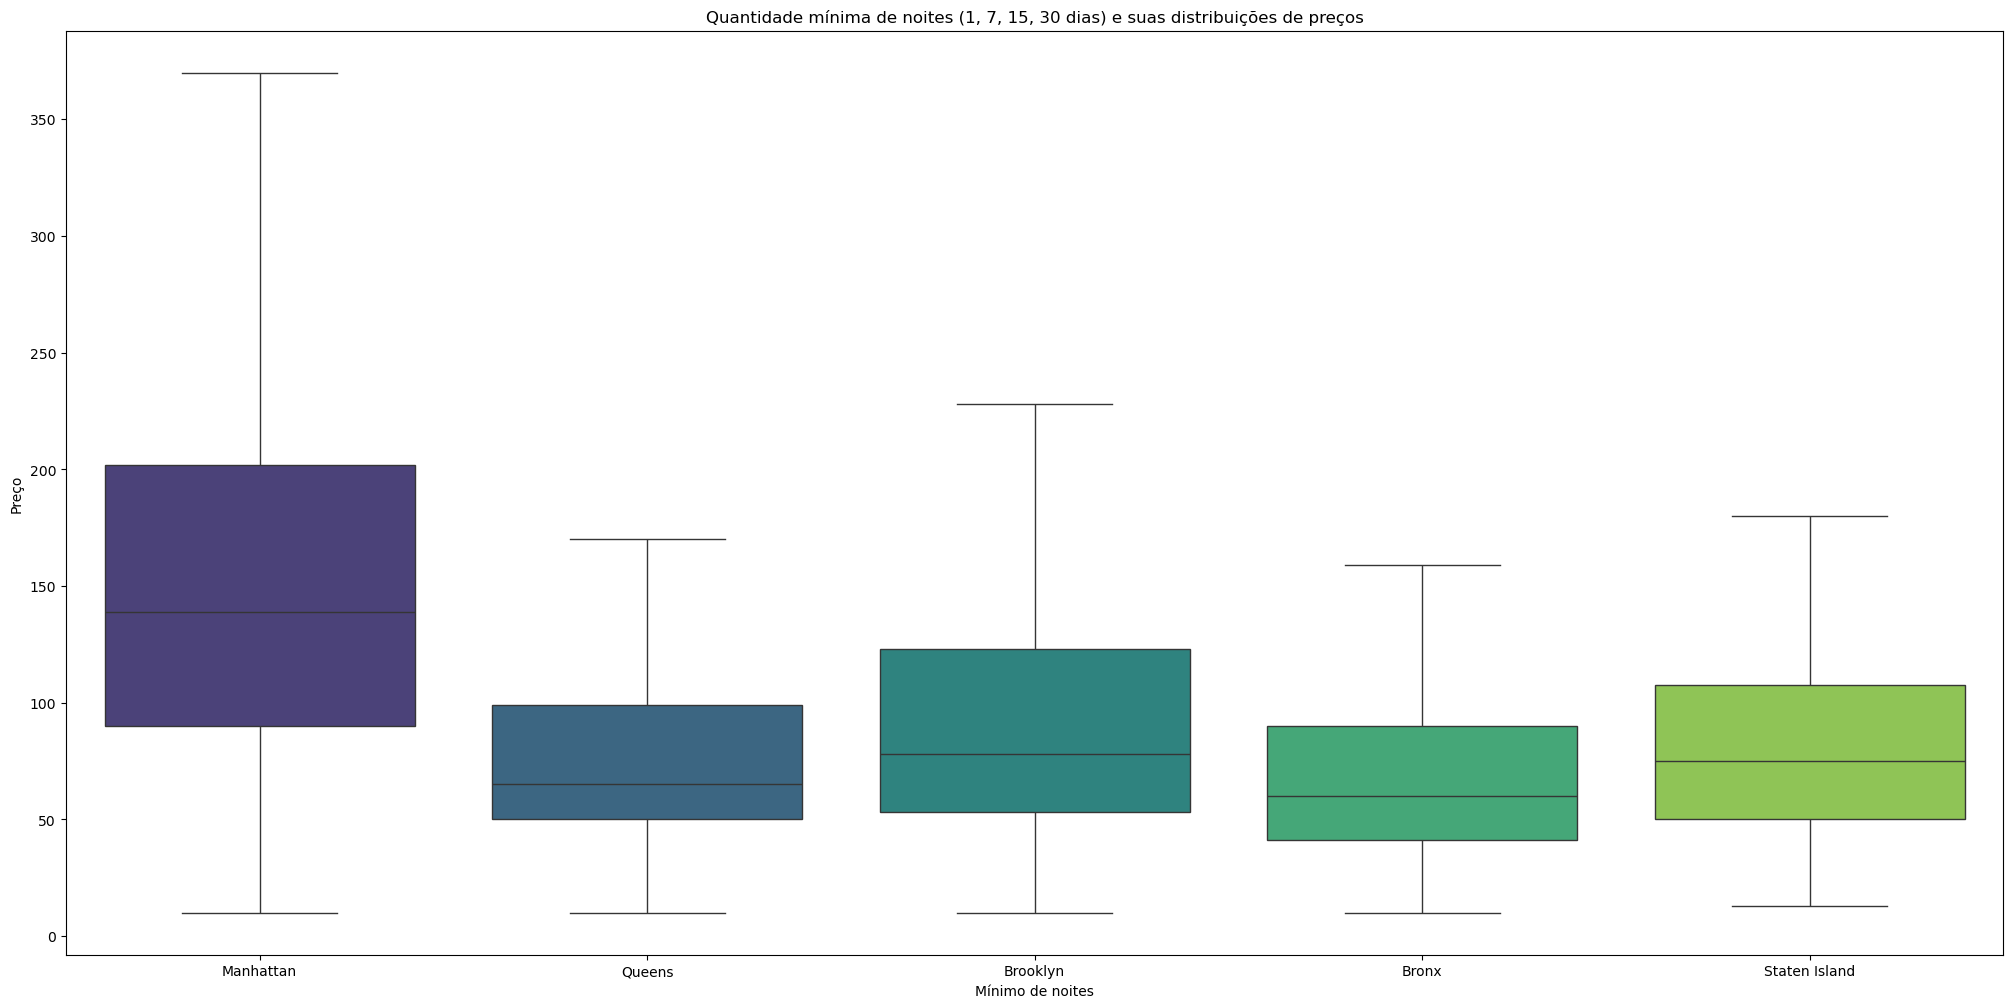

In [17]:
# Plot 
sns.boxplot(data=aux, x='distrito', y='price', color='blue', showfliers=False, palette='viridis')
plt.title('Quantidade mínima de noites (1, 7, 15, 30 dias) e suas distribuições de preços')
plt.xlabel('Mínimo de noites')
plt.ylabel('Preço')
plt.show()

Em Manhattan, a mediana dos preços (Q2) está acima do terceiro quartil (Q3) dos preços nos demais distritos. Isso indica que 50% dos valores de preços em Manhattan estão acima de 75% dos valores de preços nos outros distritos.

### **H7. Imóveis com localização próxima ao mar, possuem preços mais caros.**
**True** - Imóveis em Manhattan, possuem preços mais caros.

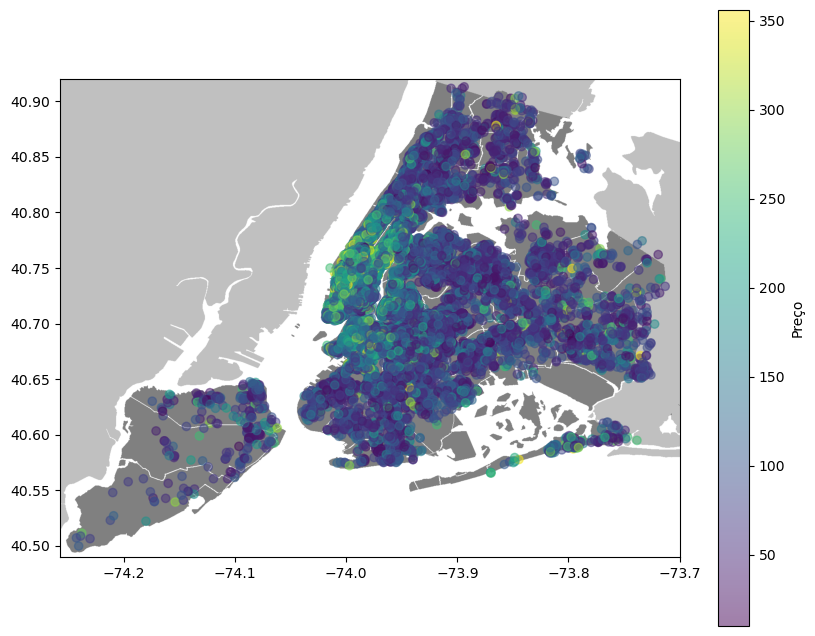

In [18]:
# Filtrando para melhorar a visualização no mapa
normal_prices = df4[df4['price'] < 358]

# # Plotar a imagem de new york
nyc_img = plt.imread('../images/nyc_map.png')
plt.figure(figsize=(10,8))
plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49, 40.92])

# Scatter plot
scatter = plt.scatter(data=normal_prices, x='longitude', y='latitude', c='price', cmap='viridis', alpha=0.5)  # Use a paleta 'viridis' ou outra paleta de sua escolha
plt.colorbar(scatter, label='Preço')
plt.show()

Observa-se que a maioria dos preços mais caros estão em Manhattan ou próximo dela.

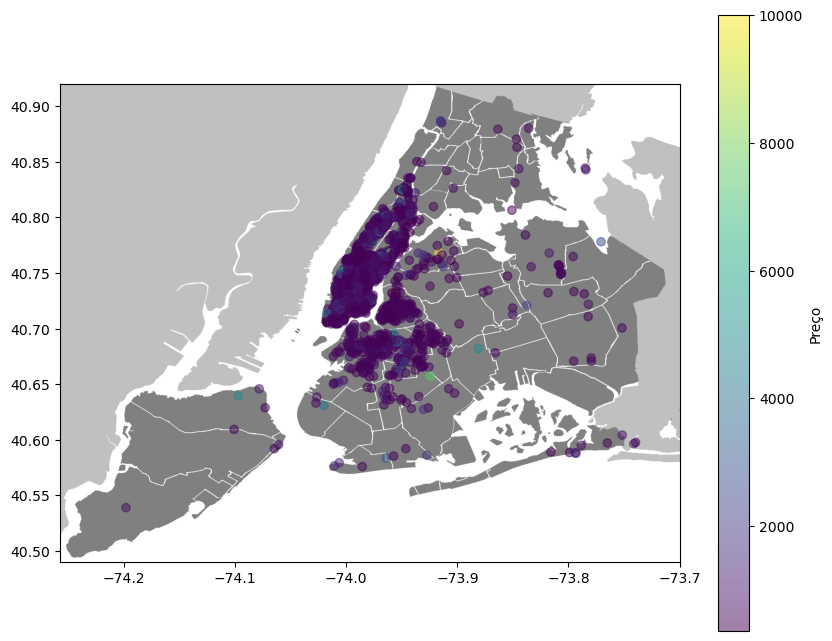

In [19]:
# Filtrando para melhorar a visualização no mapa
outlier_prices = df4[df4['price'] >= 358]

# Plotar a imagem de new york
nyc_img = plt.imread('../images/nyc_map.png')
plt.figure(figsize=(10,8))
plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49, 40.92])

# Scatter plot
scatter = plt.scatter(data=outlier_prices, x='longitude', y='latitude', c='price', cmap='viridis', alpha=0.5)  # Use a paleta 'viridis' ou outra paleta de sua escolha
plt.colorbar(scatter, label='Preço')
plt.show()

Lembrando que este segundo gráfico está filtrado para conter apenas preços outliers. A maioria também se concentra em Manhattan ou próximo dela.

### **H8. Hosts que possuem mais imóveis, possuem um preço maior.**
**False** - Hosts que possuem menos imóveis, possuem um preço maior.

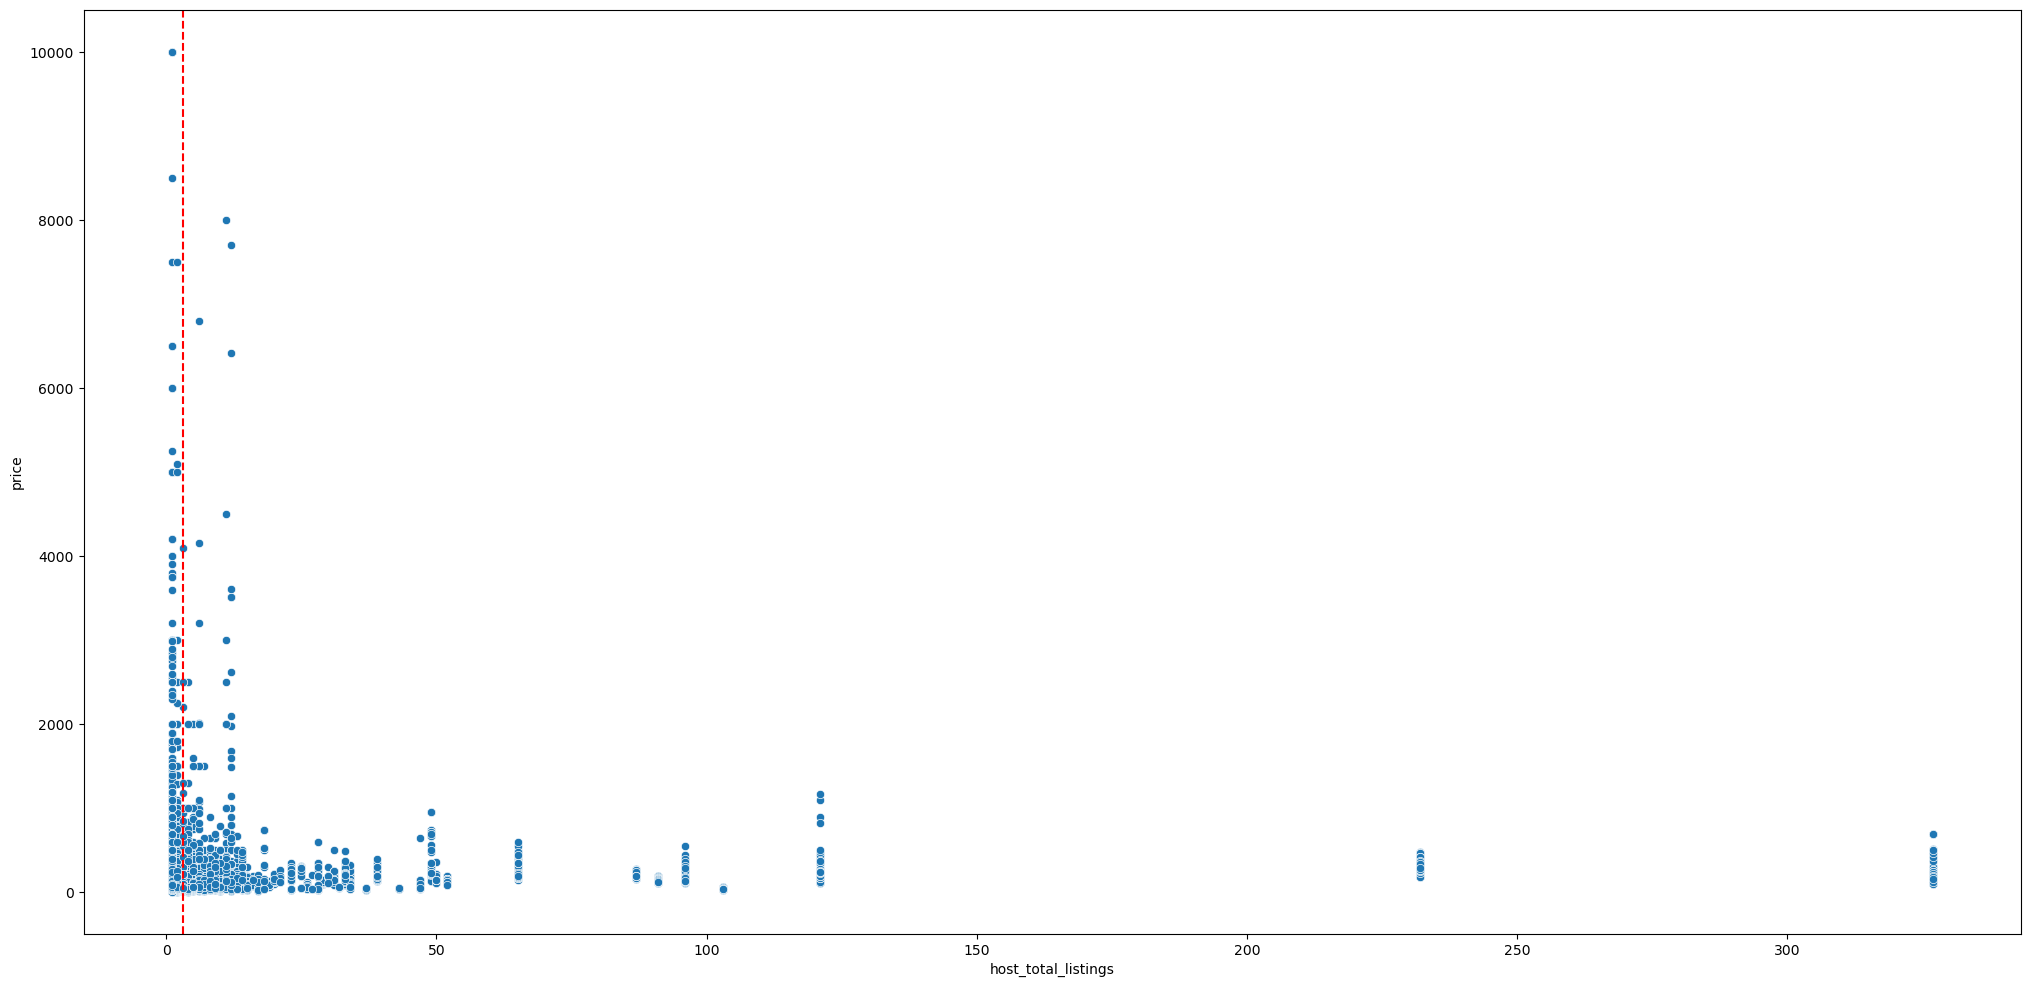

In [20]:
sns.scatterplot(data=df4, x='host_total_listings', y='price')
plt.axvline(x=3, color='r', linestyle='--')

## **4.3 Análise Multivariada**

A análise multivariada proporciona uma visão mais completa dos dados, nos ajuda na compreensão do fenômeno através da identificação de correlações, mas também é fundamental para identificar as features mais relevantes para os modelos de machine learning, auxiliando na seleção, criação ou eliminação de features para otimizar o desempenho dos modelos.

### 4.3.1 Variáveis Numéricas

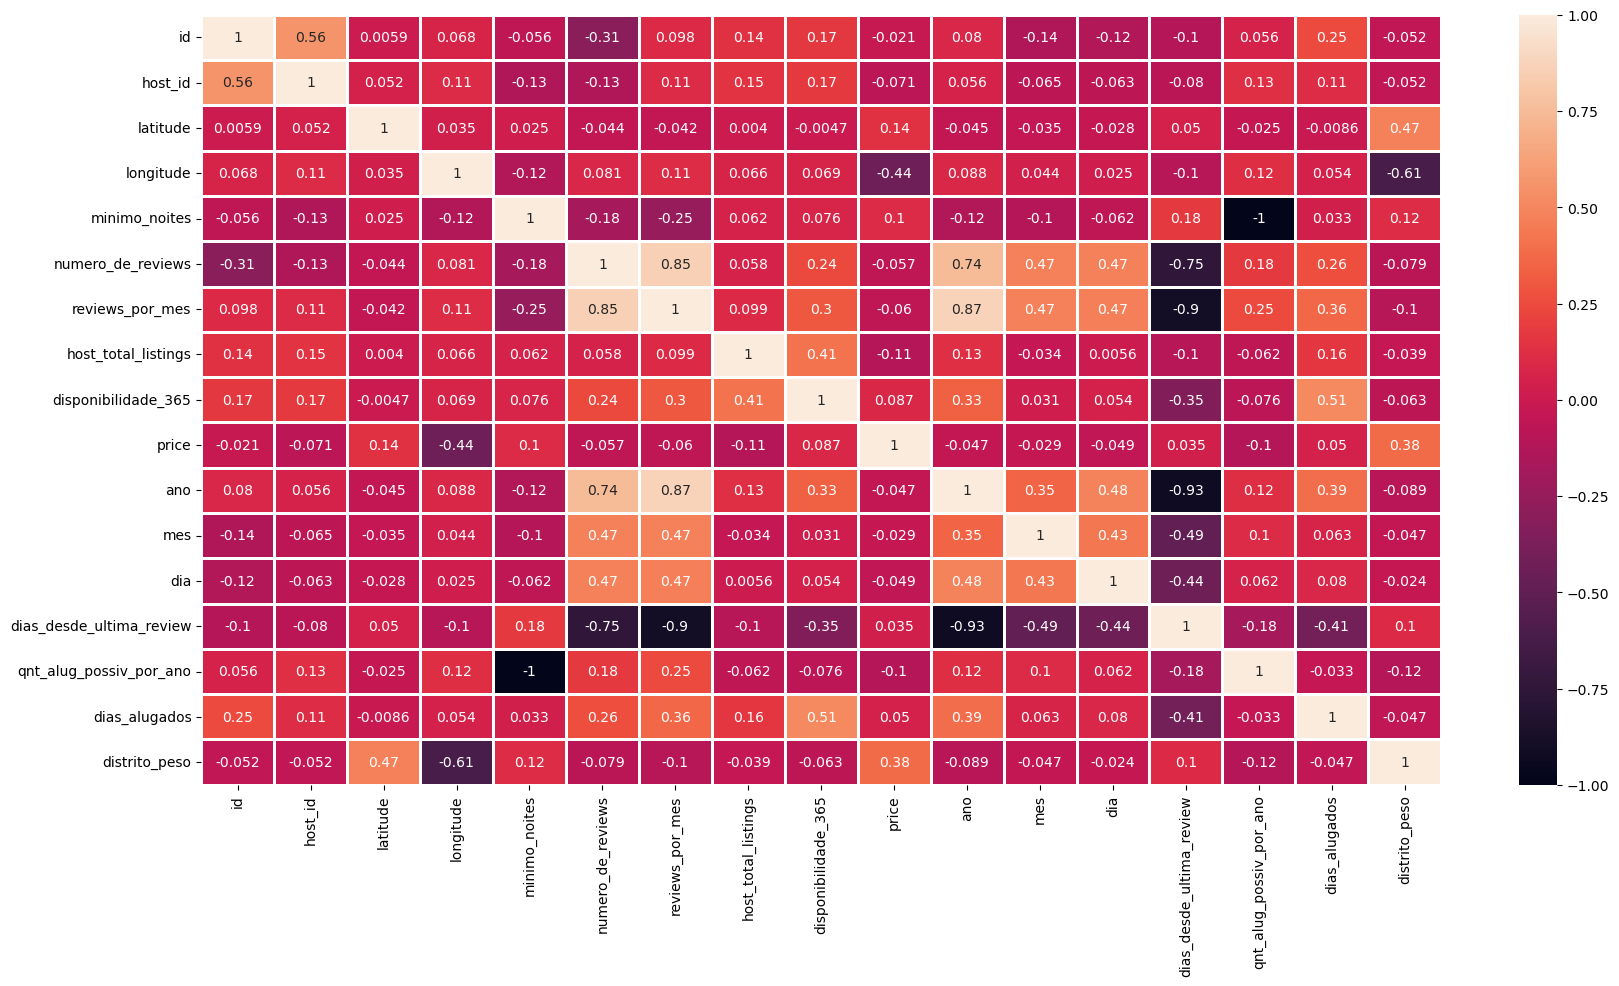

In [21]:
plt.figure(figsize=(20,10))
correlation = num_attributes.corr(method='spearman')
sns.heatmap(correlation, annot=True, linewidths=2);

### 4.3.1 Variáveis Categóricas

<Axes: >

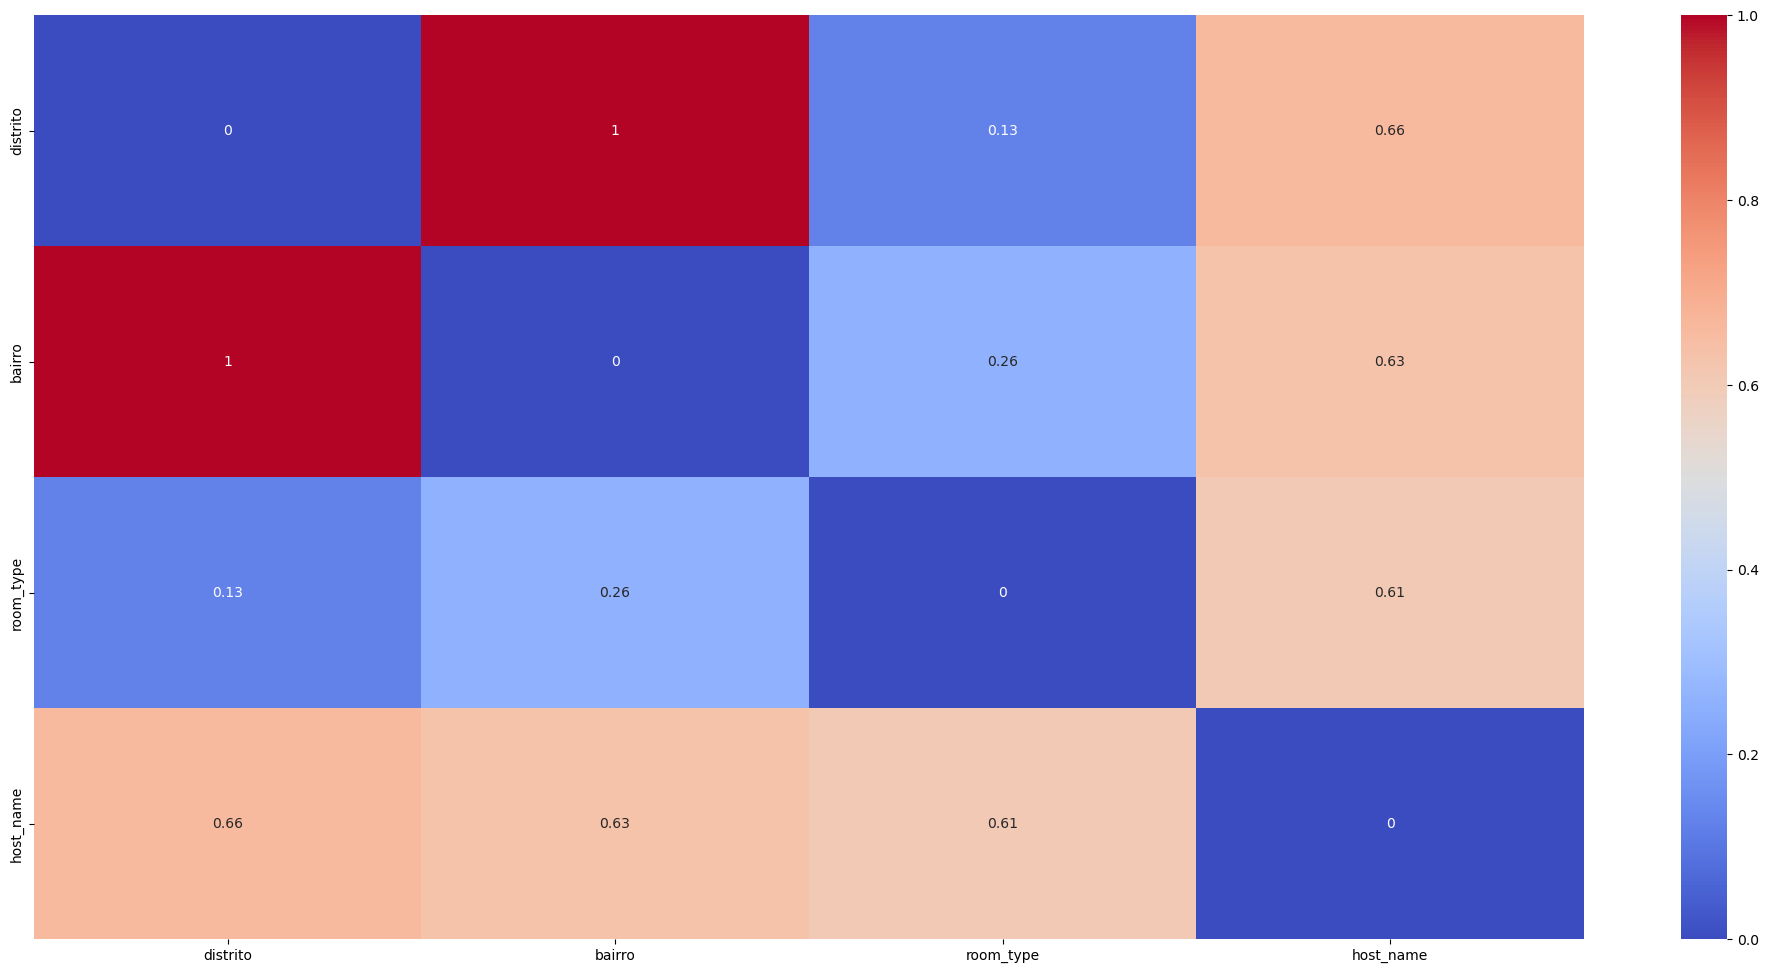

In [22]:
# Filtrando dataset - não utilizei a coluna nome, pois deturpava os valores do heatmap devido a sua alta cardinalidade. 
# Isso poderia distorcer a análise do coeficiente de Cramer's V.
cat_corr = cat_attributes[['distrito', 'bairro', 'room_type', 'host_name']].copy()

# Matriz vazia para armazenar os coeficientes de Cramer's V
cramers_v_matrix = np.zeros((len(cat_corr.columns), len(cat_corr.columns)))

# Itera sobre cada par de colunas para calcular o coeficiente de Cramer's V
for i, col1 in enumerate(cat_corr.columns):
    for j, col2 in enumerate(cat_corr.columns):
        if i != j:
            cramers_v_matrix[i, j] = cramer_v(cat_corr[col1], cat_corr[col2])

# df das correlações mais plot heatmap
cramers_v_df = pd.DataFrame(cramers_v_matrix, index=cat_corr.columns, columns=cat_corr.columns)
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm')

-------

# **5.0 Perguntas de Negócio**

## **5.1- Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?**

Eu consideraria, inicialmente, 2 fatores:

1- Encontrar o bairro/distrito dos imóveis que ficam alugados a maior parte do tempo (disponibilidade_365 menor, ou seja, a maior parte dos dias do ano já estão reservados/ocupados)

2- Encontrar os imóveis com o melhor preço médio de aluguel (mantendo a competitividade)

### **5.1.1 Identificar a melhor disponibilidade**

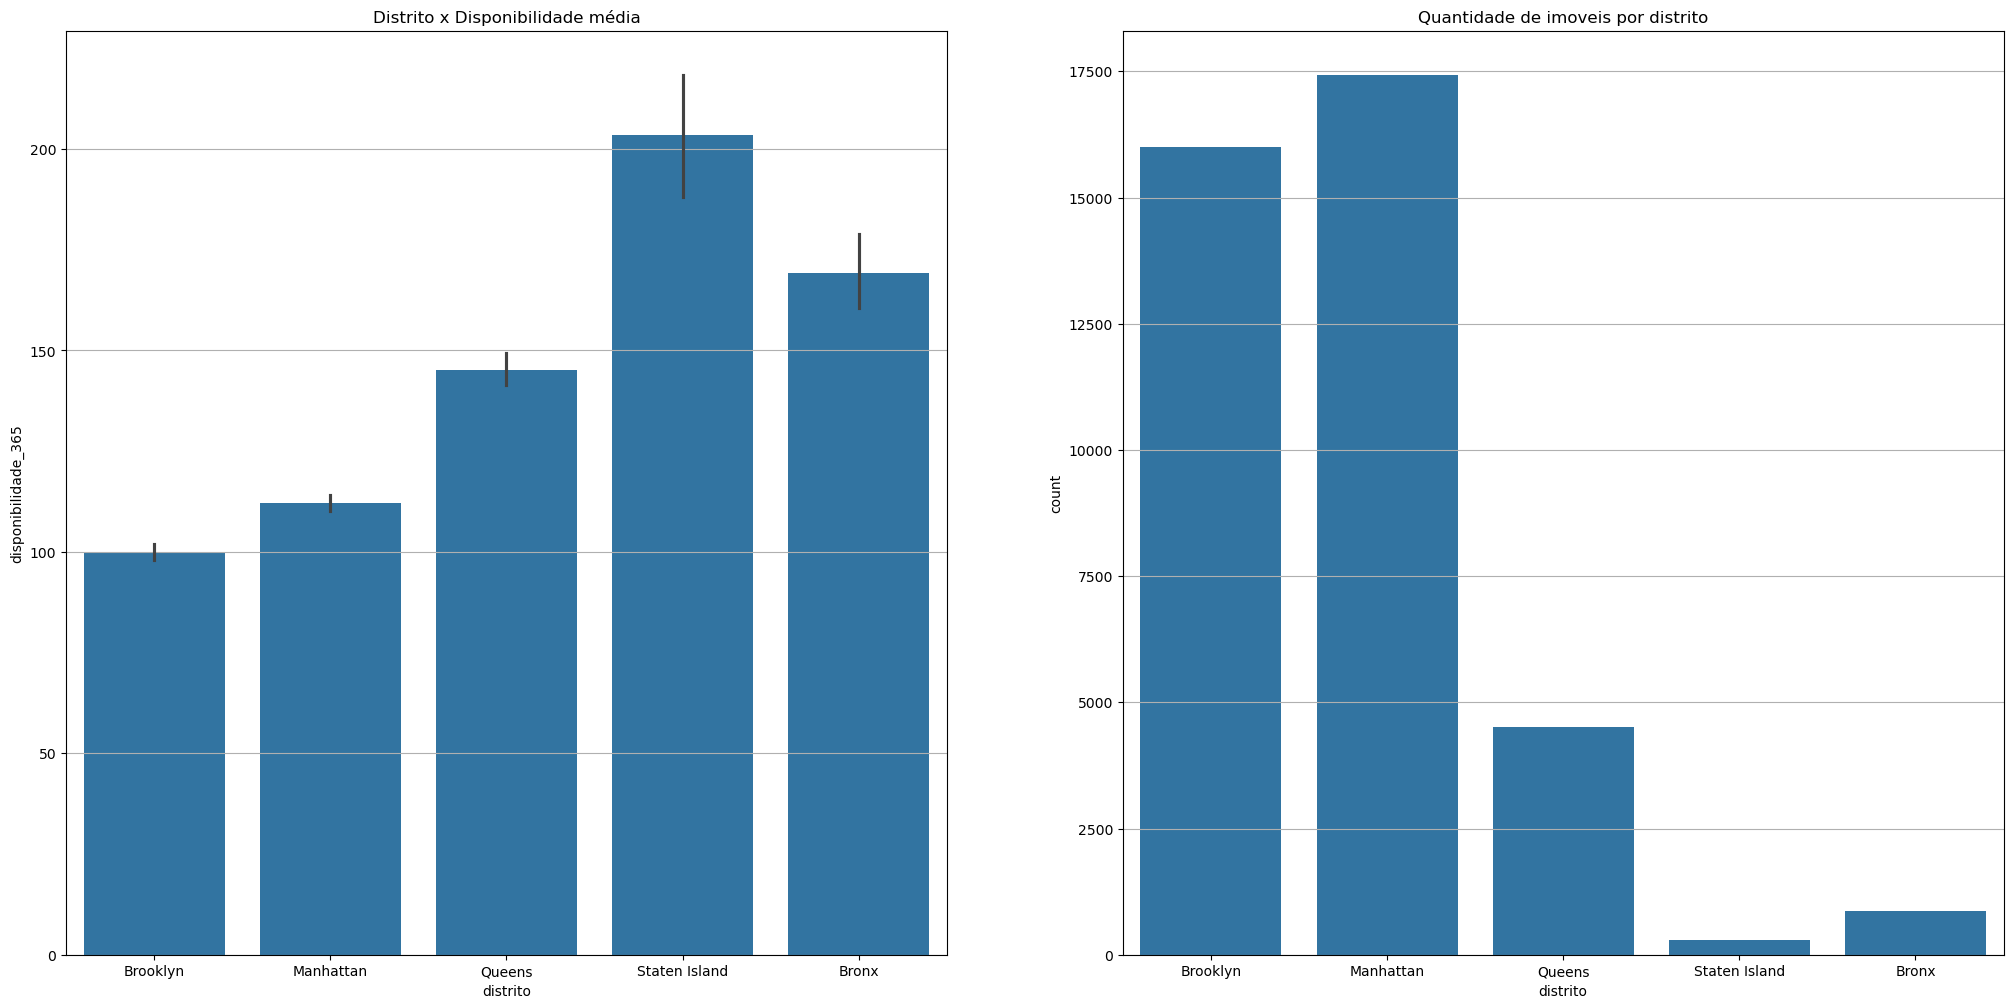

In [23]:
# Plot Distrito x Disponibilidade média
plt.subplot(1,2,1)
ab = sns.barplot(data=df4, x='distrito', y='disponibilidade_365')
plt.title('Distrito x Disponibilidade média')
ab.grid(axis='y')

# Plot Quantidade de imoveis por distrito
plt.subplot(1,2,2)
ax = sns.countplot(data=cat_attributes, x='distrito')
plt.title('Quantidade de imoveis por distrito')
ax.grid(axis='y')

É possível observar que Brooklyn e Manhattan possuem as menores disponibilidades, ou seja, são mais requisitados em média. São também os dois distritos com a maior quantidade de imóveis para aluguel, com uma diferença aproximada de 12500 imóveis, a mais para Manhattan.

Nota-se também que os dois distritos, Staten Island e Bronx, apresentam as menores quantidades de imóveis e as maiores disponibilidades (baixa procura), assim, considero estes distritos com pouquíssima demanda, descartando-os para um possível investimento. 

A seguir, verifico a distribuição estatística dos dados de disponibilidade dos distritos por meio do boxplot.

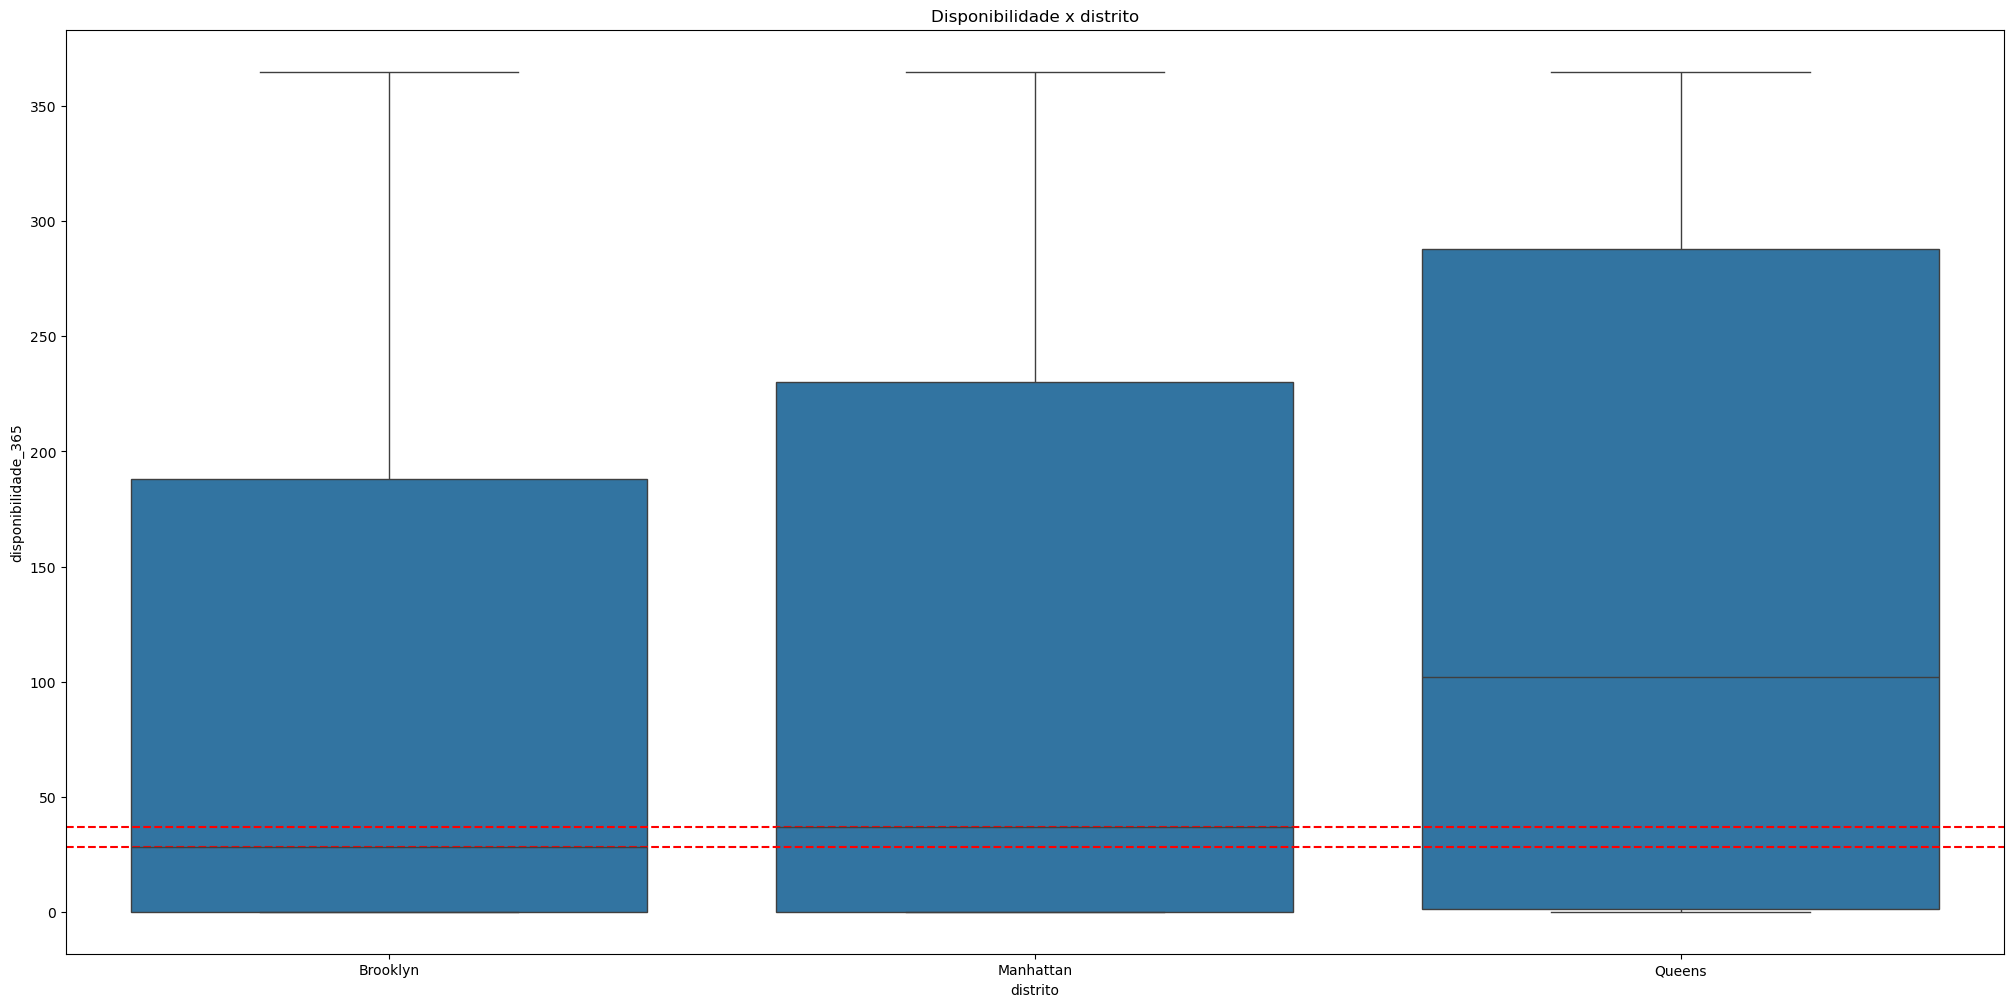

In [24]:
# Plot boxplot Disponibilidade x distrito
box_disp = df4[df4['distrito'].isin(['Manhattan', 'Queens', 'Brooklyn'])]
sns.boxplot(data=box_disp, x='distrito', y='disponibilidade_365')
plt.title('Disponibilidade x distrito')
plt.axhline(y=28, color='r', linestyle='--')
plt.axhline(y=37, color='r', linestyle='--')

Brooklyn e Manhattan possuem disponibilidades semelhantes, detre os 50% (até Q2), pois possuem uma diferença interquartil medianal de 9 dias. 

Assim seguirei a análise com apenas estes dois distritos.

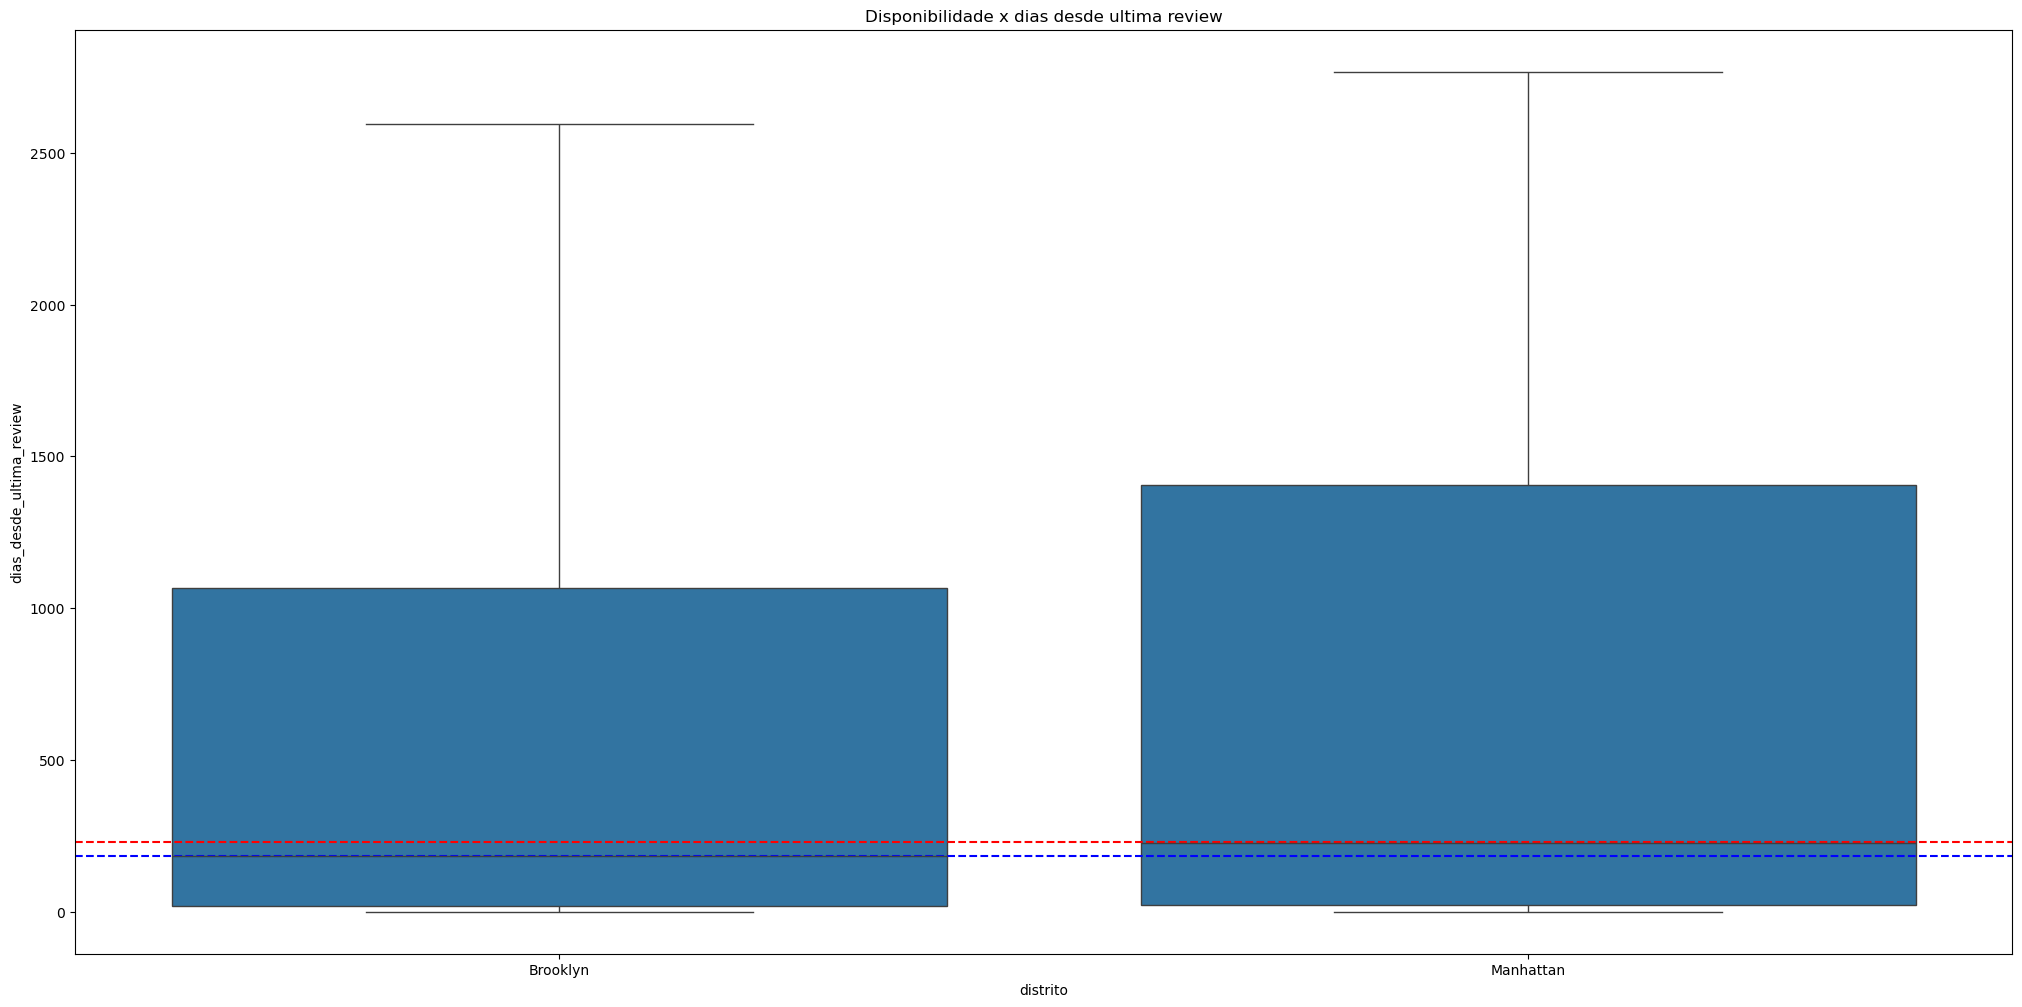

In [25]:
# Disponibilidade x dias desde ultima review
df_distritos = df4[df4['distrito'].isin(['Brooklyn', 'Manhattan'])]
sns.boxplot(data=df_distritos, x='distrito', y='dias_desde_ultima_review', showfliers=False)
plt.title('Disponibilidade x dias desde ultima review')
plt.axhline(y=182, color='blue', linestyle='--')
plt.axhline(y=230, color='r', linestyle='--')

Considerando que a review deve ser feita logo após o encerramento do aluguel, os dois demonstraram uma movimentação semelhante, mas sendo o
Brooklyn o melhor, com 50% dos seus valores abaixo de 180 dias desde a última review (6 meses) e Manhattan 230 dias (aprox. 8 meses). 

No geral, Brooklyn possui menores dias desde a ultima review, ou seja, possui movimentações mais recentes.

Prosseguirei para tentar confirmar a ideia de reviews recentes. 

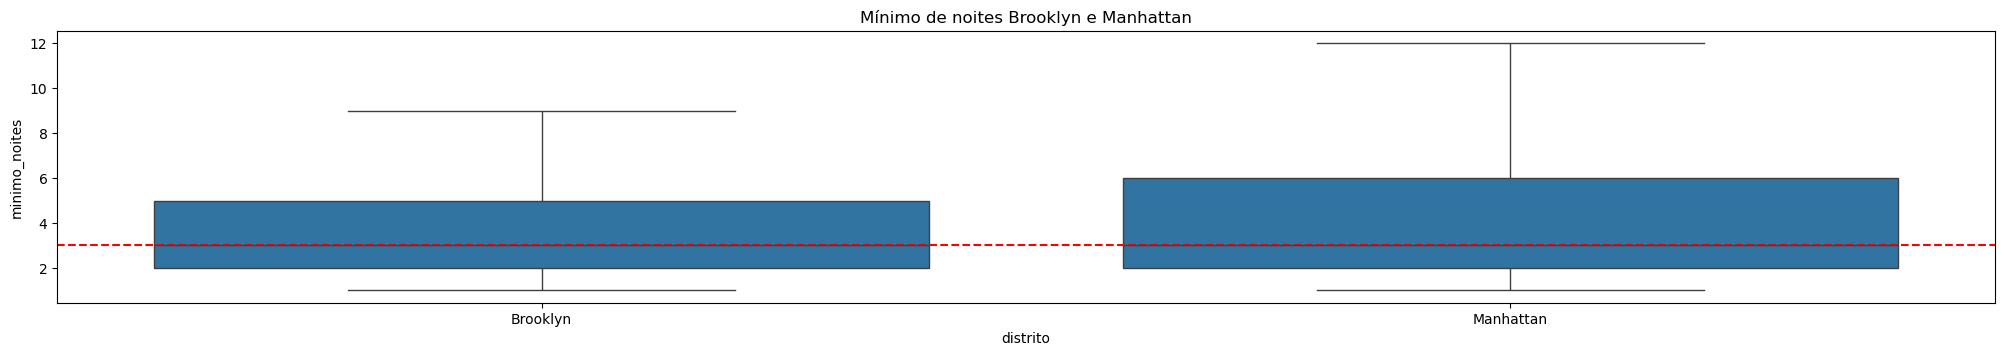

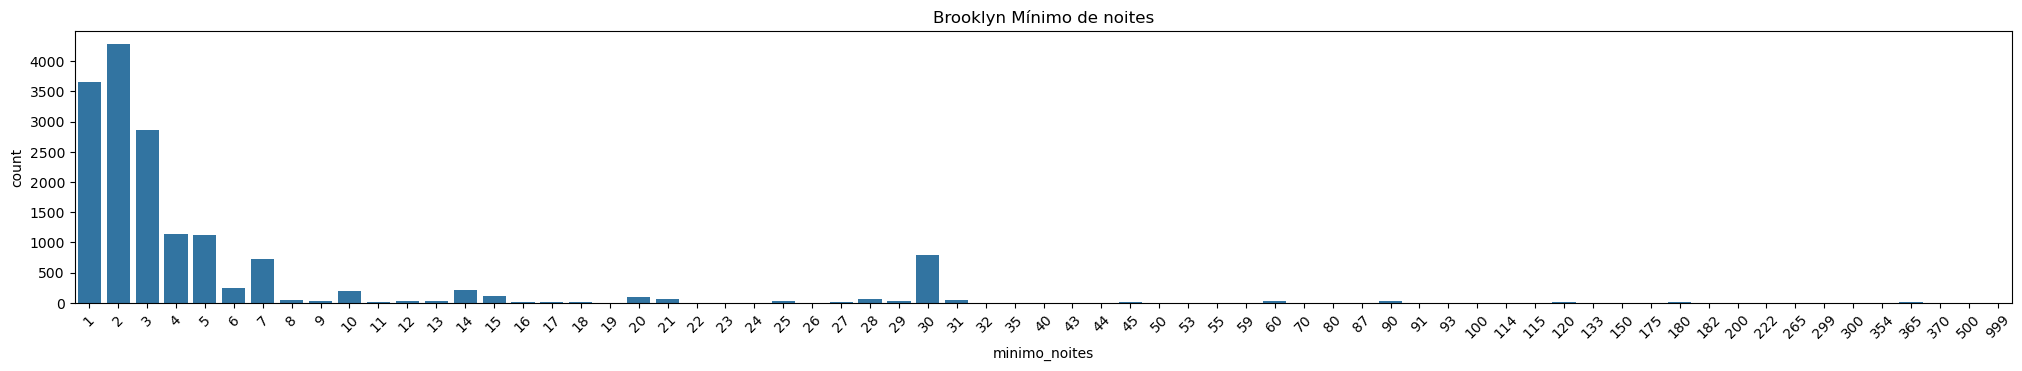

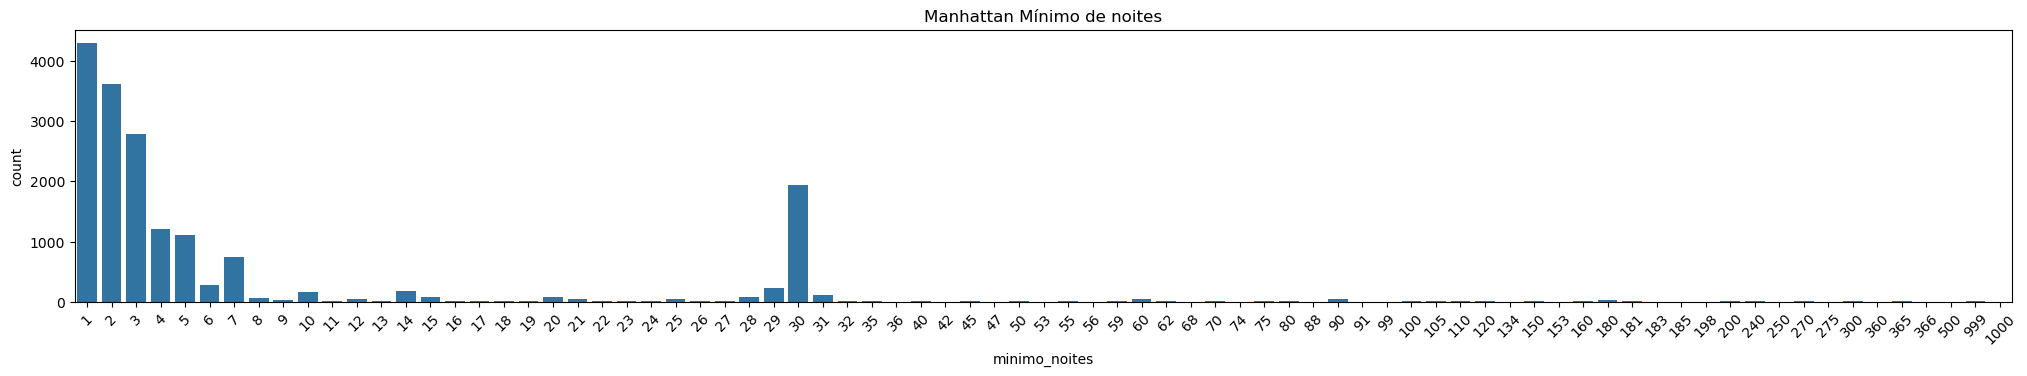

In [26]:
# Mínimo de noites Brooklyn e Manhattan
plt.subplot(3,1,1)
df_distritos = df4[df4['distrito'].isin(['Brooklyn', 'Manhattan'])]
sns.boxplot(data=df_distritos, x='distrito', y='minimo_noites', showfliers=False)
plt.axhline(y=3, color='r', linestyle='--')
plt.title('Mínimo de noites Brooklyn e Manhattan')
plt.show()

# Brooklyn Mínimo de noites
plt.subplot(3,1,2)
df_B = df4[df4['distrito'] == 'Brooklyn']
sns.countplot(data=df_B, x='minimo_noites')
plt.title('Brooklyn Mínimo de noites')
plt.xticks(rotation=45)
plt.show()

# Manhattan Mínimo de noites
plt.subplot(3,1,3)
df_M = df4[df4['distrito'] == 'Manhattan']
sns.countplot(data=df_M, x='minimo_noites')
plt.title('Manhattan Mínimo de noites')
plt.xticks(rotation=45)
plt.show()

Como a maioria dos imóveis possui entre 1 a 7 dias mínimos, interpreto como sendo um reflexo que são demandas para poucos dias, o que reafirma a ideia acima de que as reviews tendem a ser recentes, mostrando uma movimentação recente na região.

É notável também um pico em 30 dias mínimos, indicando que alguns hosts preferem que o imóvel esteja alugado no mínimo 1 mês.

### **5.1.2 Identificar o melhor preço médio**

Uma vez analisado a disponibilidade (demanda pelo imóvel) fator crucial para encontrar a resposta para a pergunta de negócio, analisarei os preços, pois para o imóvel ser um bom investimento, este deve ser bem requisitado e gerar um bom faturamento.

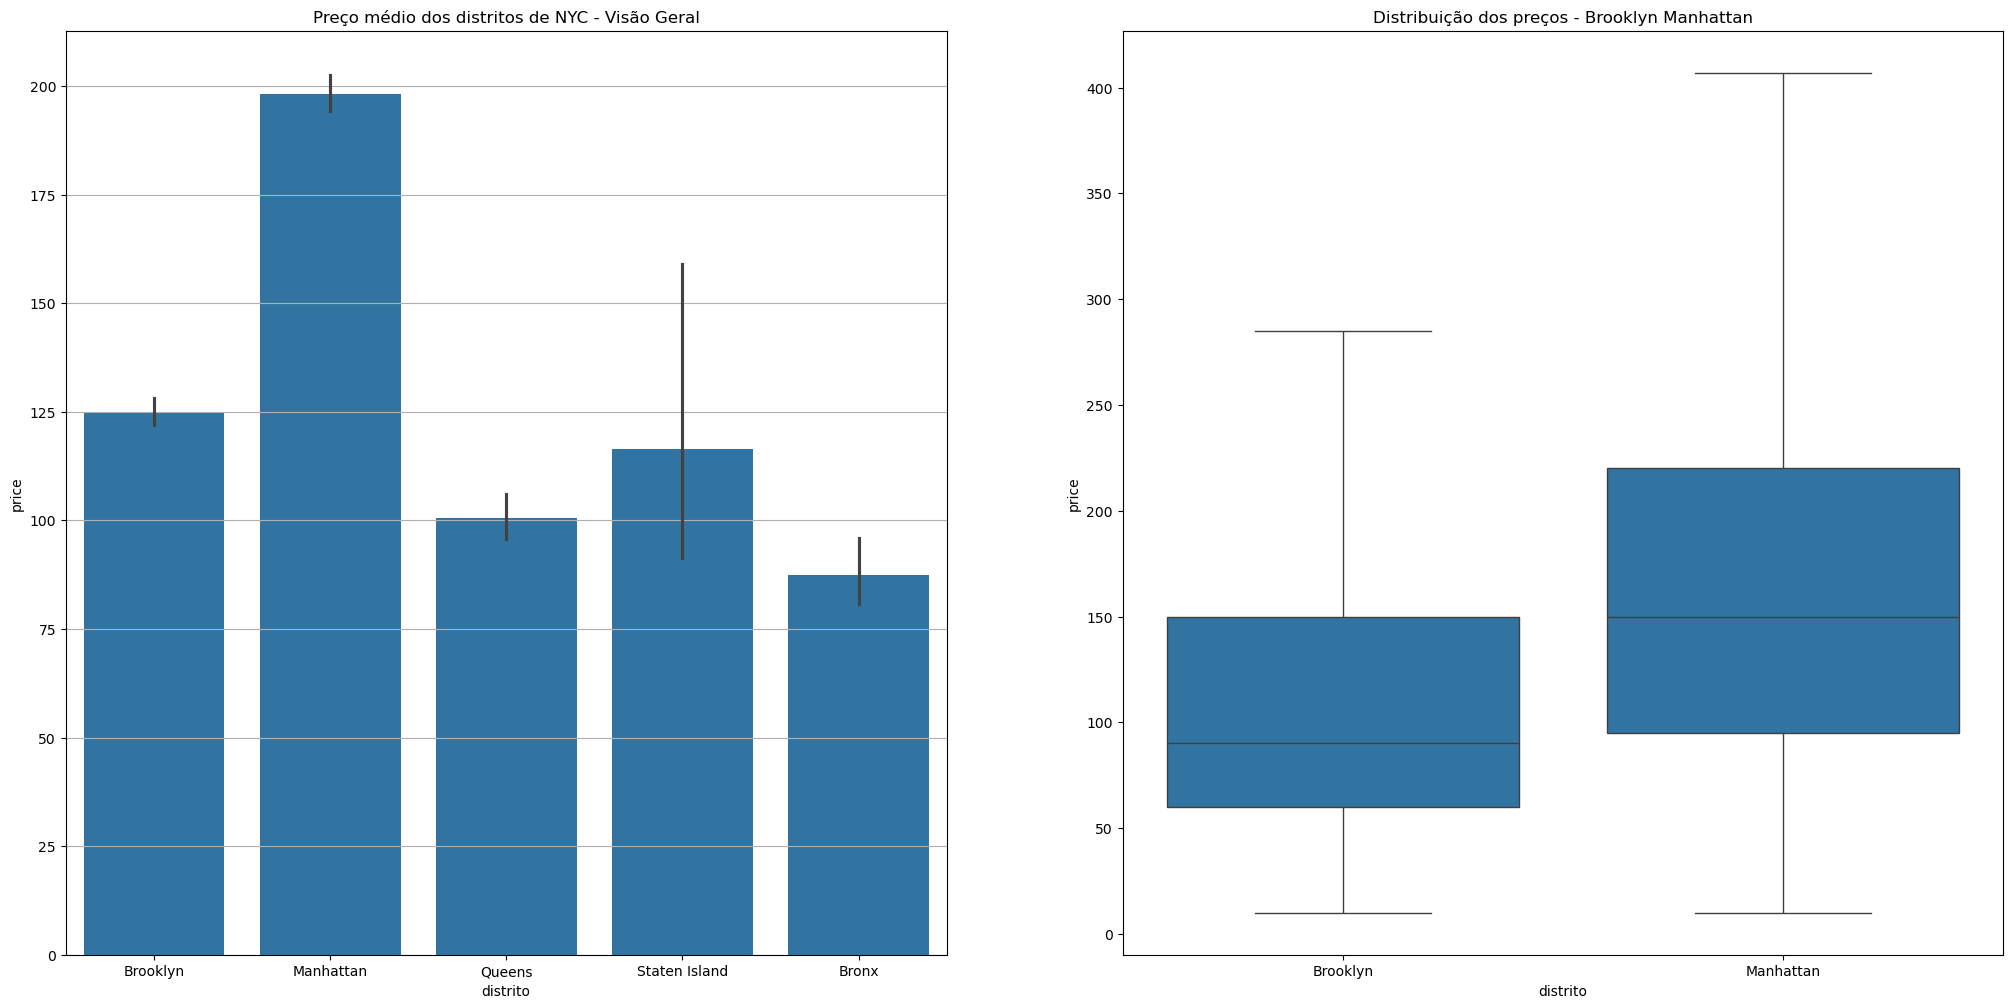

In [27]:
# Plot preços médio
plt.subplot(1,2,1)
ab = sns.barplot(data=df4, x='distrito', y='price')
ab.grid(axis='y')
plt.title('Preço médio dos distritos de NYC - Visão Geral')

# Plot Distribuição dos preços - Brooklyn Manhattan
plt.subplot(1,2,2)
df_distritos = df4[df4['distrito'].isin(['Brooklyn', 'Manhattan'])]
sns.boxplot(data=df_distritos, x='distrito', y='price', showfliers=False)
plt.title('Distribuição dos preços - Brooklyn Manhattan')
plt.show()

Manhattan apresentou o maior preço médio e uma maior mediana, indicando uma distribuição de preços geralmente mais elevada em comparação com Brooklyn, 
onde a mediana (de Manhattan) está no mesmo nível que o terceiro quartil Q3 (do Brooklyn).

### **5.1.3 Identificar o melhor bairro e tipo de imóvel (room_type)**

A diferença entre a disponibilidade em Manhattan e Brooklyn é pequena, no entanto, optaria por Manhattan devido a oportunidade de obter maiores ganhos, uma vez que o preço médio é o dobro do preço médio em Brooklyn.

Sendo assim, sigo a análise com o distrito de Manhattan, para encontrar o melhor bairro e melhor tipo de imóvel (room_type)

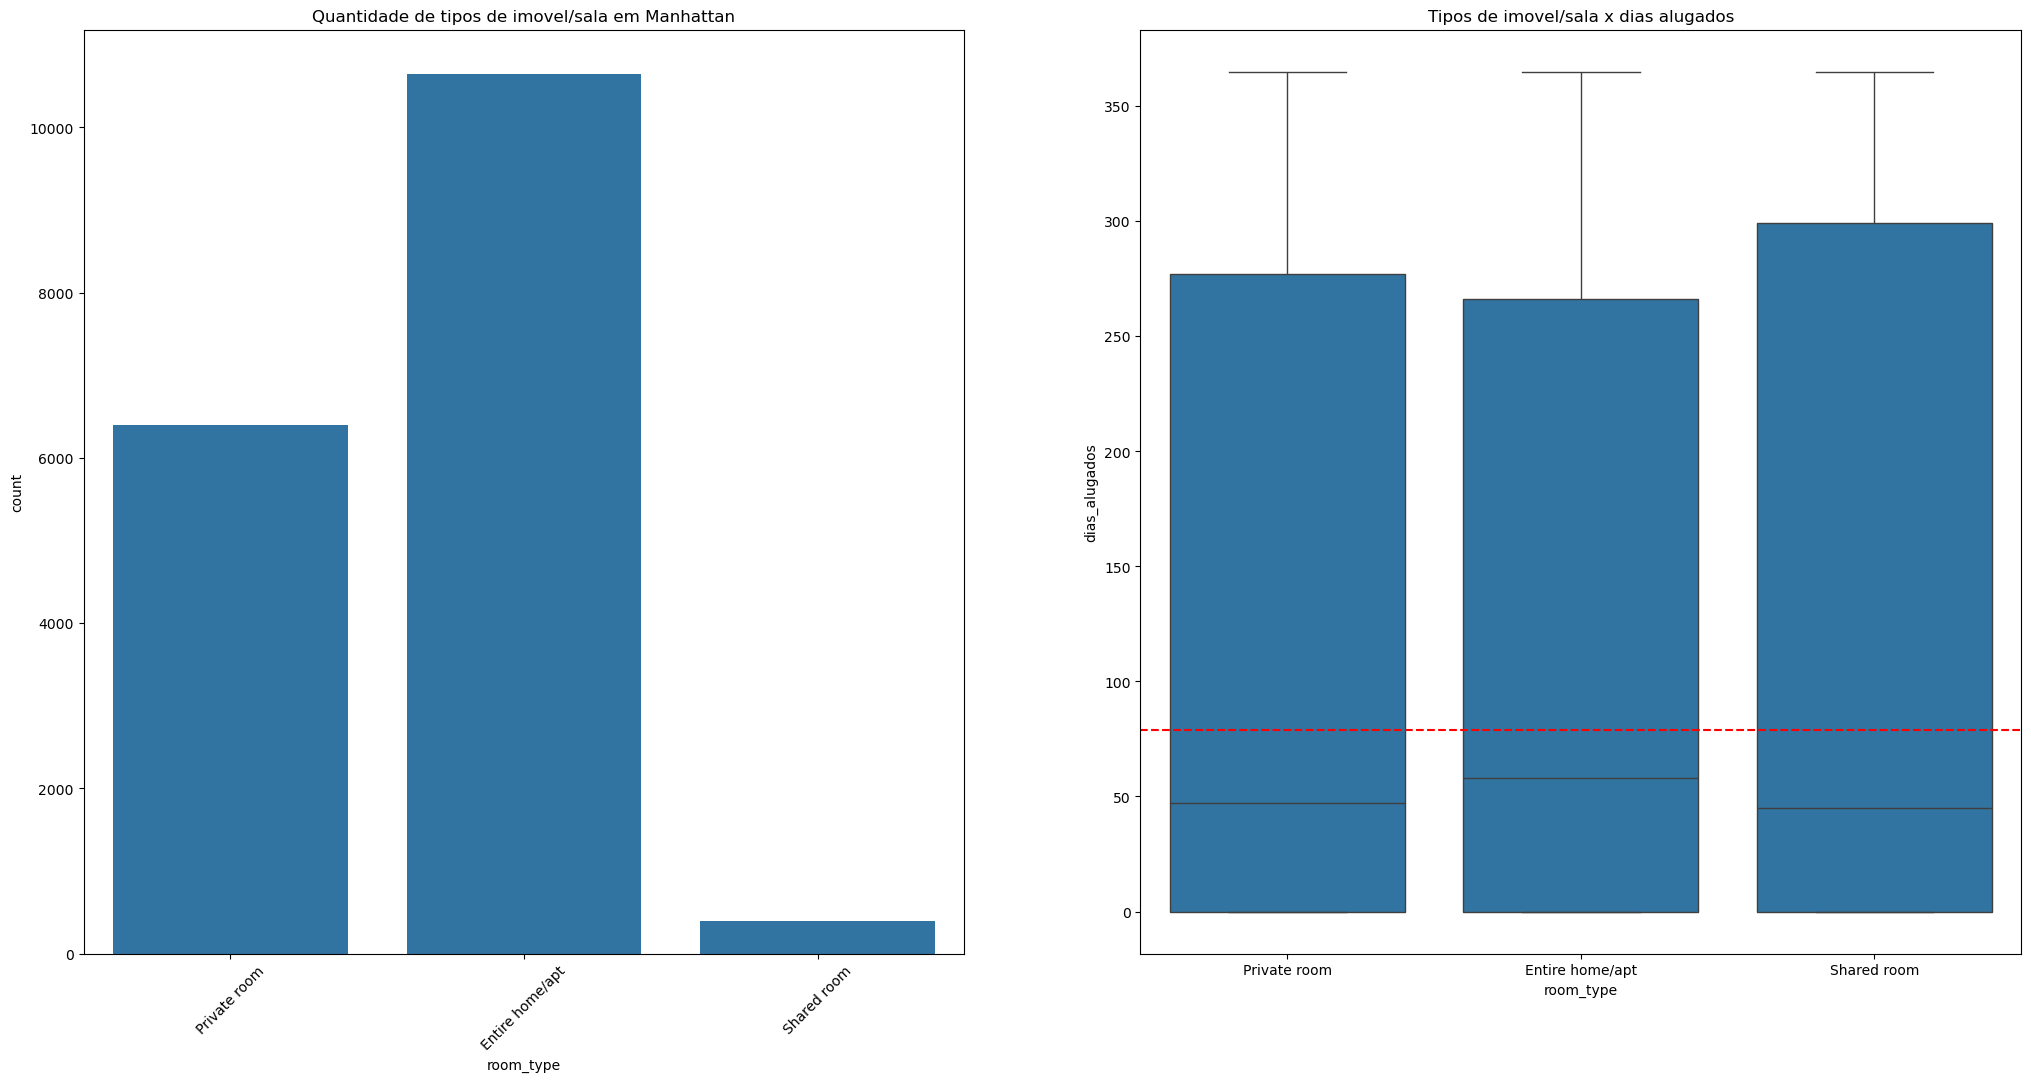

room_type
Entire home/apt    0.611025
Private room       0.366661
Shared room        0.022314
Name: proportion, dtype: float64

In [28]:
# Filtrando apenas para distrito Manhattan
df_manhattan = df4[df4['distrito'] == 'Manhattan']

# Quantidade de tipos de imovel/sala em Manhattan
plt.subplot(1,2,1)
sns.countplot(data=df_manhattan, x='room_type')
plt.title('Quantidade de tipos de imovel/sala em Manhattan')
plt.xticks(rotation=45)

# Tipos de imovel/sala x dias alugados
plt.subplot(1,2,2)
sns.boxplot(data=df_manhattan, x='room_type', y='dias_alugados', showfliers=False)
plt.title('Tipos de imovel/sala x dias alugados')
plt.axhline(y=79, color='r', linestyle='--')
plt.show()

df_manhattan['room_type'].value_counts(normalize=True)

Em uma análise simples de contagem, notamos que a maioria dos imóveis em Manhattan pertence ao tipo Entire home/apt, representando 61% do total de tipos de imóveis na região.

Embora Manhattan tenha a mediana mais alta de valores de aluguel, isso por si só não é suficiente para determinar o tipo de imóvel mais procurado. Para uma compreensão mais completa da demanda, farei agora um histograma das categorias de tipos de imóveis, onde analisarei a quantidade de imóveis e a quantidade de dias alugados. Isso nos fornecerá uma visão mais abrangente da demanda por diferentes tipos de imóveis em Manhattan.

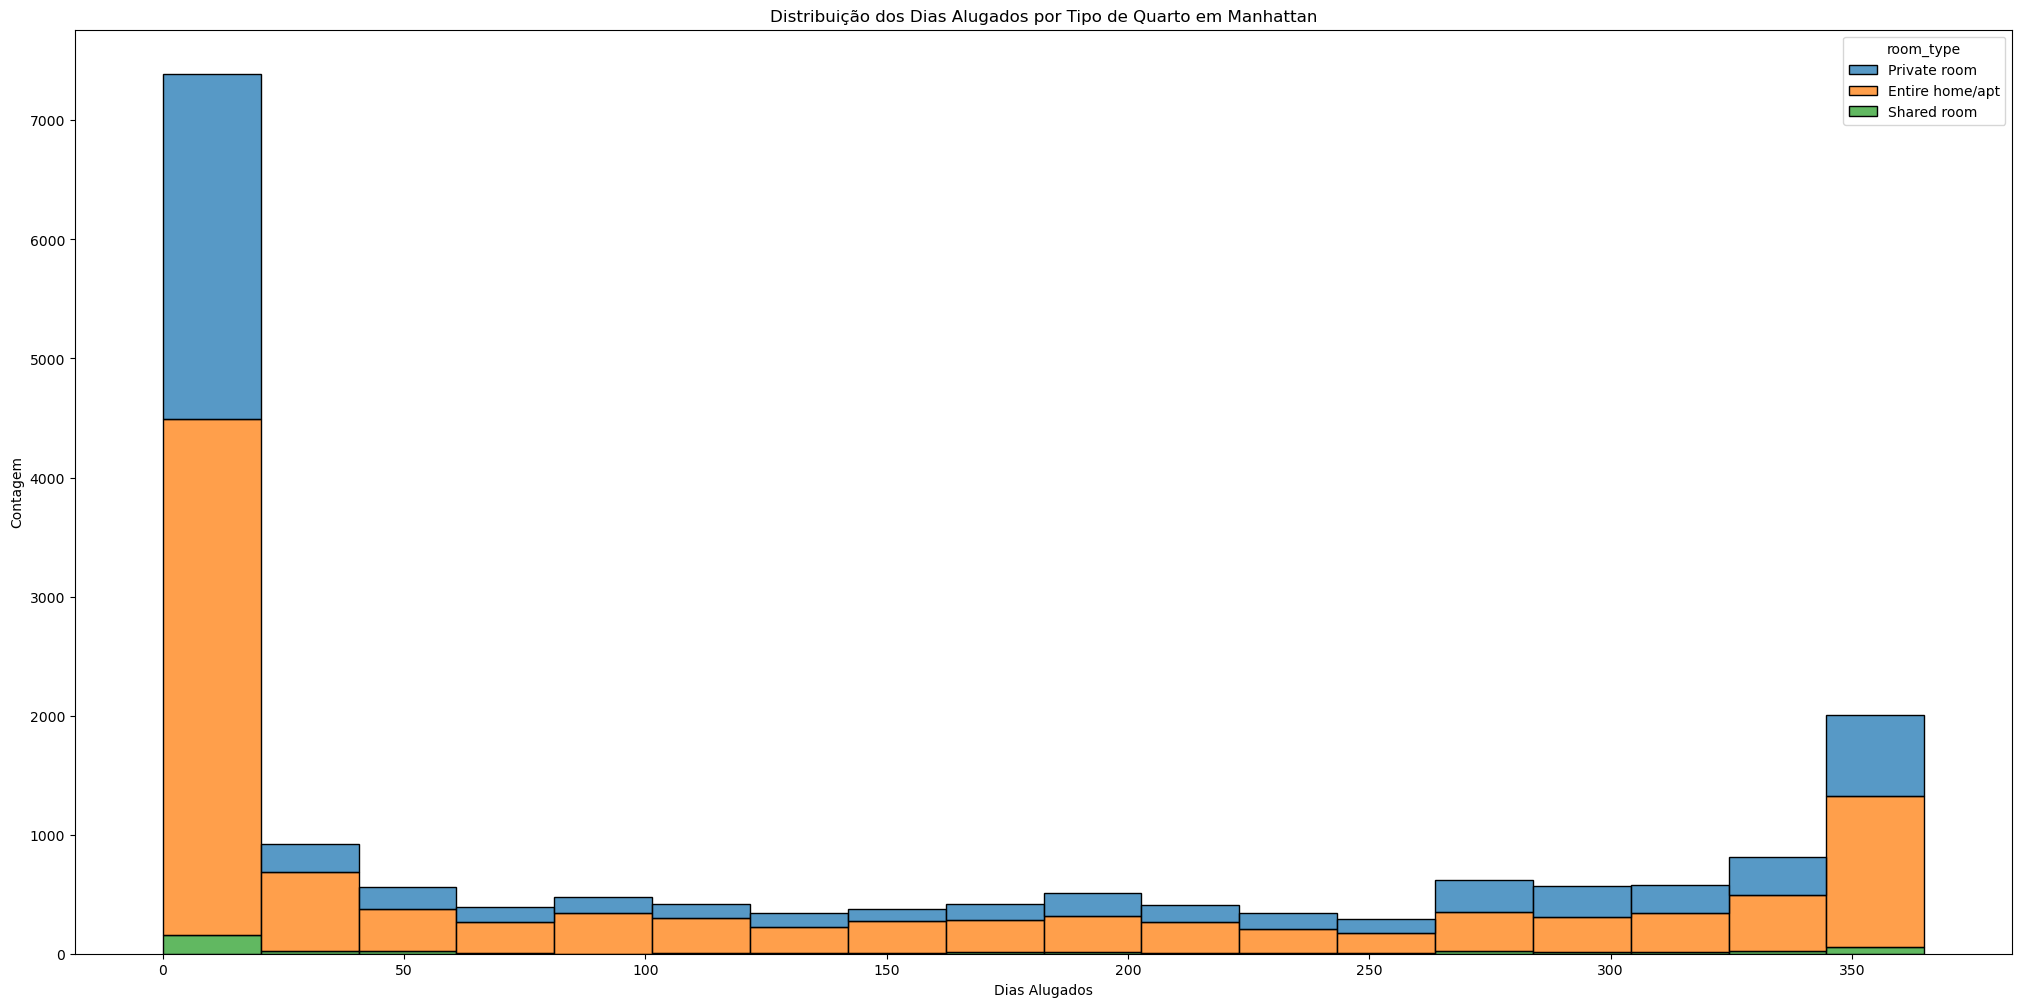

In [29]:
# Distribuição dos Dias Alugados por Tipo de Quarto em Manhattan
df_manhattan = df4[df4['distrito'] == 'Manhattan']
sns.histplot(data=df_manhattan, x='dias_alugados', hue='room_type', multiple='stack')
plt.title('Distribuição dos Dias Alugados por Tipo de Quarto em Manhattan')
plt.xlabel('Dias Alugados')
plt.ylabel('Contagem')
plt.show()

Observa-se neste histograma que o tipo "Entire home/apt" realmente é o que possui mais dias alugados, refletindo uma alta demanda por residências completas para aluguel. Isso sugere que os visitantes e moradores têm preferência por espaços completos e privativos durante suas estadias em Manhattan.

Em seguida, verificarei a distribuição dos preços do tipo de sala "Entire home/apt".

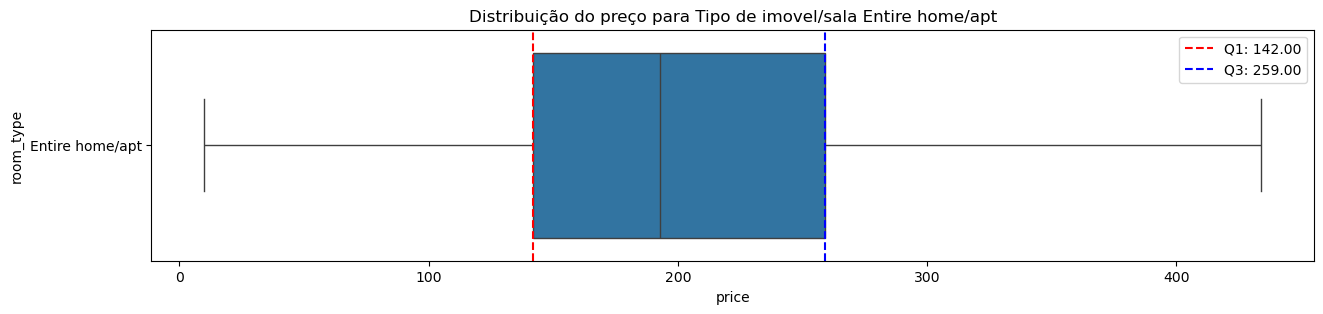

In [30]:
# Filtrando distrito de Manhattan e Entire home/apt
df_man_apt_price = df4[(df4['distrito'] == 'Manhattan') & (df4['room_type'] == 'Entire home/apt')]

# Distribuição do preço para Tipo de imovel/sala Entire home/apt
plt.figure(figsize=(15, 3))
sns.boxplot(data=df_man_apt_price, x='price', y='room_type', orient='h', showfliers=False)
q1 = df_man_apt_price['price'].quantile(0.25)
q3 = df_man_apt_price['price'].quantile(0.75)
plt.title('Distribuição do preço para Tipo de imovel/sala Entire home/apt')
plt.axvline(x=q1, color='r', linestyle='--', label='Q1: {:.2f}'.format(q1))
plt.axvline(x=q3, color='b', linestyle='--', label='Q3: {:.2f}'.format(q3))
plt.legend()
plt.show()


Utilizarei o range entre Q1 e Q3, ou seja, os 50% dos preços mais próximos da mediana, para delimitar o eixo de preços da área dos melhores imóveis para se alugar.

Abaixo encontro essa área.

In [31]:
# Filtrando datasets
df_manhattan = df4[df4['distrito'] == 'Manhattan']
df_man_apt = df_manhattan[df_manhattan['room_type'] == 'Entire home/apt']

# Criando ranges para a área dos melhores imoveis
min_price = 142 # valor de q1
max_price = 259 # valor de q3
min_disp = 0 # quanto menor melhor, pois mostra que o imóvel é muito procurado
max_disp = 0 # quanto menor melhor, pois mostra que o imóvel é muito procurado

# Filtra os dados dentro da área desejada
df_area = df_man_apt[(df_man_apt['price'] >= min_price) & (df_man_apt['price'] <= max_price) & (df_man_apt['disponibilidade_365'] >= min_disp) & (df_man_apt['disponibilidade_365'] <= max_disp)]

fig = px.scatter(df_area, x='price', y='disponibilidade_365', color='bairro', hover_data=['bairro'])
fig.update_layout(
    title='Disponibilidade em função do Preço por Distrito',
    xaxis_title='Preço',
    yaxis_title='Disponibilidade')
fig.show()

df_area['bairro'].value_counts().head()

bairro
East Village       252
Upper West Side    238
Upper East Side    193
West Village       160
Chelsea            140
Name: count, dtype: int64

Considerando as características até aqui descritas, além dos imóveis altamente requisitados e com faixa de preço correspondente a 50% dos valores da região, abaixo está a lista dos top 5 melhores bairros de Manhattan, distrito de NYC, para se investir em um imóvel para aluguel.


| Bairros de Manhattan | Quantidade de imóveis totalmente alugados - Disponibilidade 0 |
|---------------------|----------------------------------------------------------|
| East Village        | 252                                                      |
| Upper West Side     | 238                                                      |
| Upper East Side     | 193                                                      |
| West Village        | 160                                                      |
| Chelsea             | 140                                                      |


### 5.1.4 Conclusão

Sendo assim, o melhor lugar para comprar é:
- Distrito de Manhattan;
- Bairro de East Village;
- Tipo do imóvel: Entire home/apt.

Pois a sala Entire home/apt, no bairro East Village, do distrito de Manhattan, apresentou a maior procura (menor disponibilidade) e com os melhores preços.

-----

## **5.2 Verificar se o número mínimo de noites e a disponibilidade ao longo do ano, influência no preço do imóvel.**

### 5.2.1 Analisando através do scatterplot

In [32]:
# Criando o scatterplot com Plotly Express
fig = px.scatter(df4, x='minimo_noites', y='disponibilidade_365', color='price', 
                 title='Relação entre Preço do Imóvel, Número Mínimo de Noites e Disponibilidade ao Longo do Ano')

# Adicionando rótulos aos eixos
fig.update_xaxes(title='Número Mínimo de Noites')
fig.update_yaxes(title='Disponibilidade')
fig.show()

O scatterplot não nos mostra algo significativo. A seguir verificarei a correlação dessas features.

### 5.2.2 Verificando as correlações das features

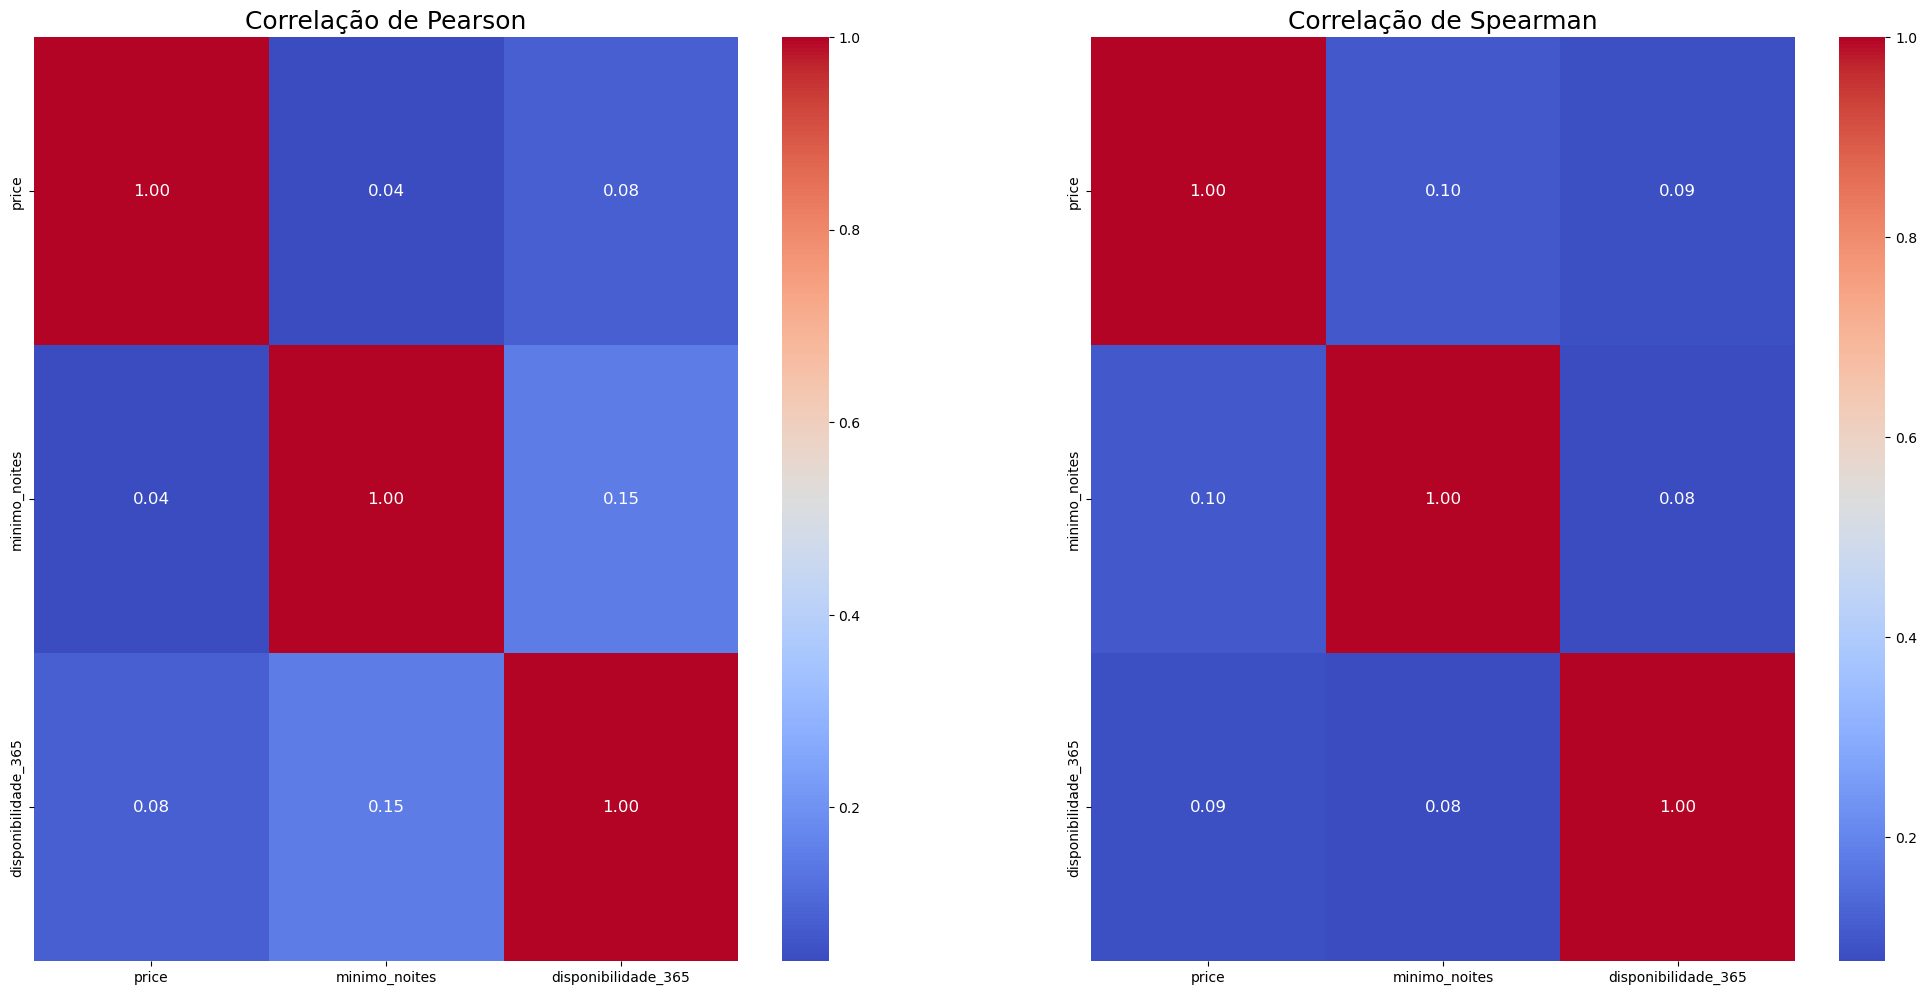

In [33]:
# Calculando a correlação entre as variáveis
corr_pearson = df4[['price', 'minimo_noites', 'disponibilidade_365']].corr('pearson')
corr_spearman = df4[['price', 'minimo_noites', 'disponibilidade_365']].corr('spearman')

# Plot Corr Pearson
# plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
heatmap = sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
heatmap.set_title('Correlação de Pearson', fontsize=18)
# plt.show()

# Plot Corr Spearman
# plt.figure(figsize=(10, 8))
plt.subplot(1,2,2)
heatmap = sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
heatmap.set_title('Correlação de Spearman', fontsize=18)
plt.show()

Os valores plotados acima, nos mostram correlações muito fracas entre as features analisadas. Então, o número mínimo de noites e a disponibilidade não possuem correlação direta com o preço do imóvel. É importante ressaltar que correlação não implica causalidade. Embora as correlações sejam insignificantes entre elas, não nos permite concluir que há uma relação direta de causa e efeito entre essas variáveis, talvez estas em conjunto com outras features, podem desempenhar influencia maior ou menor sobre o target (preço).

-----

## **5.3 Verificar se existe algum padrão no texto dos nomes dos locais mais caros (valores maiores).**

Para solucionar essa pergunta, utilizarei a biblioteca NLTK de processamento de linguagem natural (NLP), para limpar o texto, removendo stopwords, caracteres especiais, etc. Em seguida crio a coluna nome_splited_num e a coluna quantidade, que serão explicadas a seguir. 

In [34]:
# Baixar a lista de stopwords em inglês caso ainda não tenha feito isso
nltk.download('stopwords')

# Carregar os dados
# Remover acentos e caracteres especiais e deixar minúsculas
def limpar_texto(texto):
    texto = normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII') # Remover acentos
    texto = ''.join(e for e in texto if e.isalnum() or e.isspace()) # Remover caracteres especiais
    return texto.lower() # Converter para minúsculas

df4['nome_splited'] = df4['nome'].apply(limpar_texto)

# Remover stopwords em inglês
stop_words = set(stopwords.words('english'))
df4['nome_splited'] = df4['nome_splited'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Dividir cada linha da coluna 'nome_splited' em várias linhas e manter o price associado a cada palavra
df_words = pd.DataFrame(df4['nome_splited'].str.split().tolist(), index=df4['price']).stack().reset_index()
df_words.columns = ['price', 'index', 'nome_splited']
df_words = df_words.drop('index', axis=1)

# Criar coluna nome_spllited e quantidade de nome splitted mais valor
df_words['nome_splited_num'] = df_words['nome_splited'] + "_" + "price" + "_"+ df_words['price'].astype(str)
df_words['quantidade'] = df_words['nome_splited_num'].map(df_words['nome_splited_num'].value_counts())
df_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


price  nome_splited       nome_splited_num  quantidade
0          60       private       private_price_60         292
1          60          room          room_price_60         471
2          60          cozy          cozy_price_60         168
3          60  scandinavian  scandinavian_price_60           1
4          60      brooklyn      brooklyn_price_60         117
...       ...           ...                    ...         ...
196409    180         grand        grand_price_180           4
196410     90       private       private_price_90         172
196411     90       bedroom       bedroom_price_90         145
196412     90          east          east_price_90          48
196413     90       village       village_price_90          31

[196414 rows x 4 columns]

A coluna nome_splited, contém os as palavras separadas dos anúncios, seguido pela coluna price que mantém o preço do anúncio para cada palavra desse anúncio, por exemplo: 

Antes...
| nome         | price |
|--------------|-------|
| grand_hotel  | 100   |

Depois...
| nome_splited | price |
|--------------|------|
| grand        | 100  |
| hotel        | 100  |

Após isso, eu concatenei as palavras da coluna nome_splited com a coluna price, para encontrar a quantidade real de cada palavra e seu respectivo preço, pois se isso não fosse feito, não poderia identificar a quantidade de palavras com determinado valor, por exemplo:

Antes...
| nome_splited | price | quantidade_palavras_unicas |
|--------------|-------|---------------------------|
| luxury       | 400   | 3                         |
| luxury       | 500   | 3                         |
| luxury       | 500   | 3                         |
| house        | 300   | 1                         |
| apt          | 250   | 2                        |
| apt          | 120   | 2                        |



Depois...
| price | nome_splited | nome_splited_num | quantidade |
|-------|--------------|------------------|------------|
| 400   | luxury       | luxury_price_400 | 1          |
| 500   | luxury       | luxury_price_500 | 2          |
| 250   | apt          | apt_price_250    | 1          |
| 120   | apt          | apt_price_120    | 1          |
| ...   | ...          | ...              | ...        |

Mostrando a real quantidade de cada palavra com seu específico valor.

<br>

O próximo passo é analisar a distribuição dos valores dessas palavras, através do boxplot a seguir, para termos uma noção de qual intervalo iniciaremos a seleção (filtro), que utilizarei em um scatterplot mais a diante, para encotrar os maiores valores conforme solicitado na pergunta de negócio.


Quantidade de outliers: 11045
Valor do upper whisker máximo: 357.5
Valor do Q3 price: 185.0


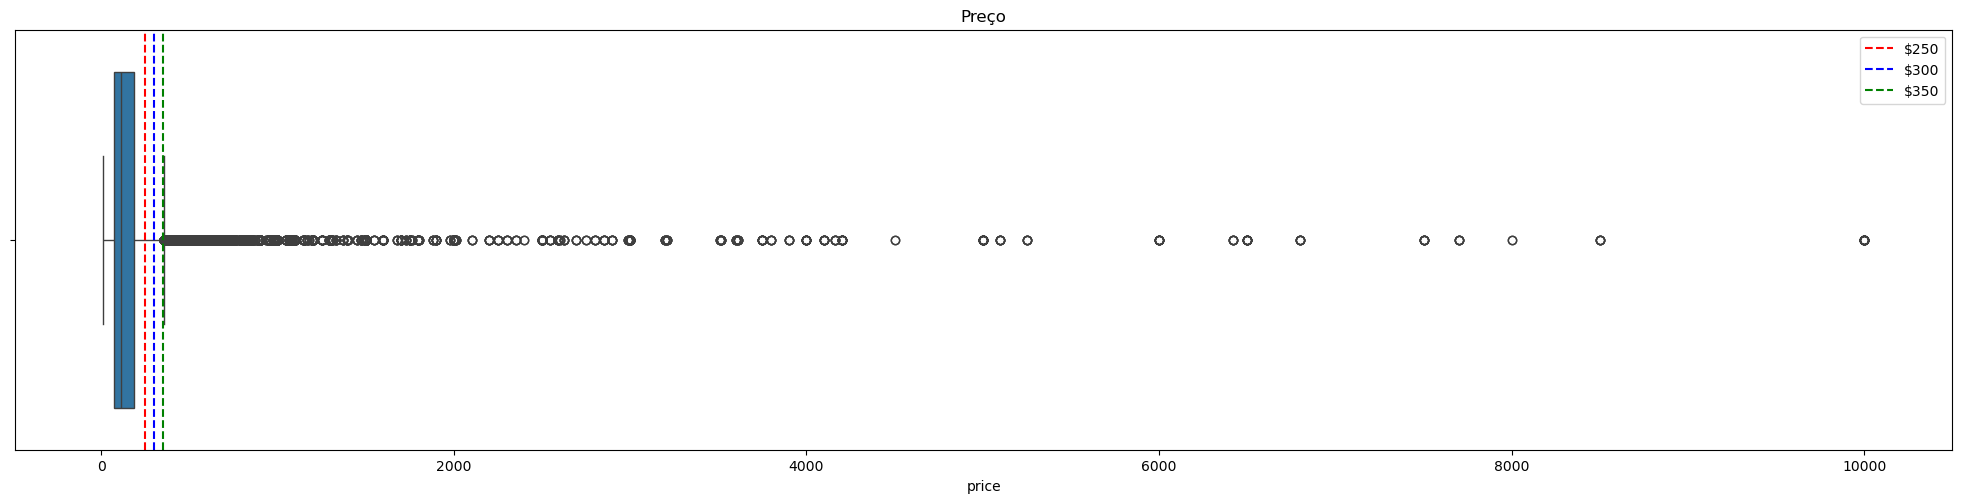

In [35]:
# Boxplot Preço
# Calculando os quartis
Q1 = df_words['price'].quantile(0.25)
Q3 = df_words['price'].quantile(0.75)

# Calculando o IQR
IQR = Q3 - Q1

# Definindo os limites dos whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Calculando a quantidade de outliers
outliers_count = len(df_words[(df_words['price'] < lower_whisker) | (df_words['price'] > upper_whisker)])

# Imprimindo os resultados
print("Quantidade de outliers:", outliers_count)
print("Valor do upper whisker máximo:", upper_whisker)
print("Valor do Q3 price:", Q3)

# Boxplot sem outliers
plt.subplot(2,1,1)
ax = sns.boxplot(data=df_words, x='price', orient='h', showfliers=True)
ax.set_title('Preço')
# plt.axvline(x=300, color='red', linestyle='--')
plt.axvline(x=250, color='r', linestyle='--', label='$250')
plt.axvline(x=300, color='b', linestyle='--', label='$300')
plt.axvline(x=350, color='g', linestyle='--', label='$350')
plt.legend()


Analisando o upper whisker e os outliers decidi selecionar a partir do preço de 350.

Quanto a quantidade significativa de outliers, ela era esperada, uma vez que os anúncios contêm múltiplas palavras e cada palavra carrega consigo o preço do anúncio, como já visto em explicações anteriores. Não há problema nisso porque nos ajudará a encontrar as palavras de maior valor.

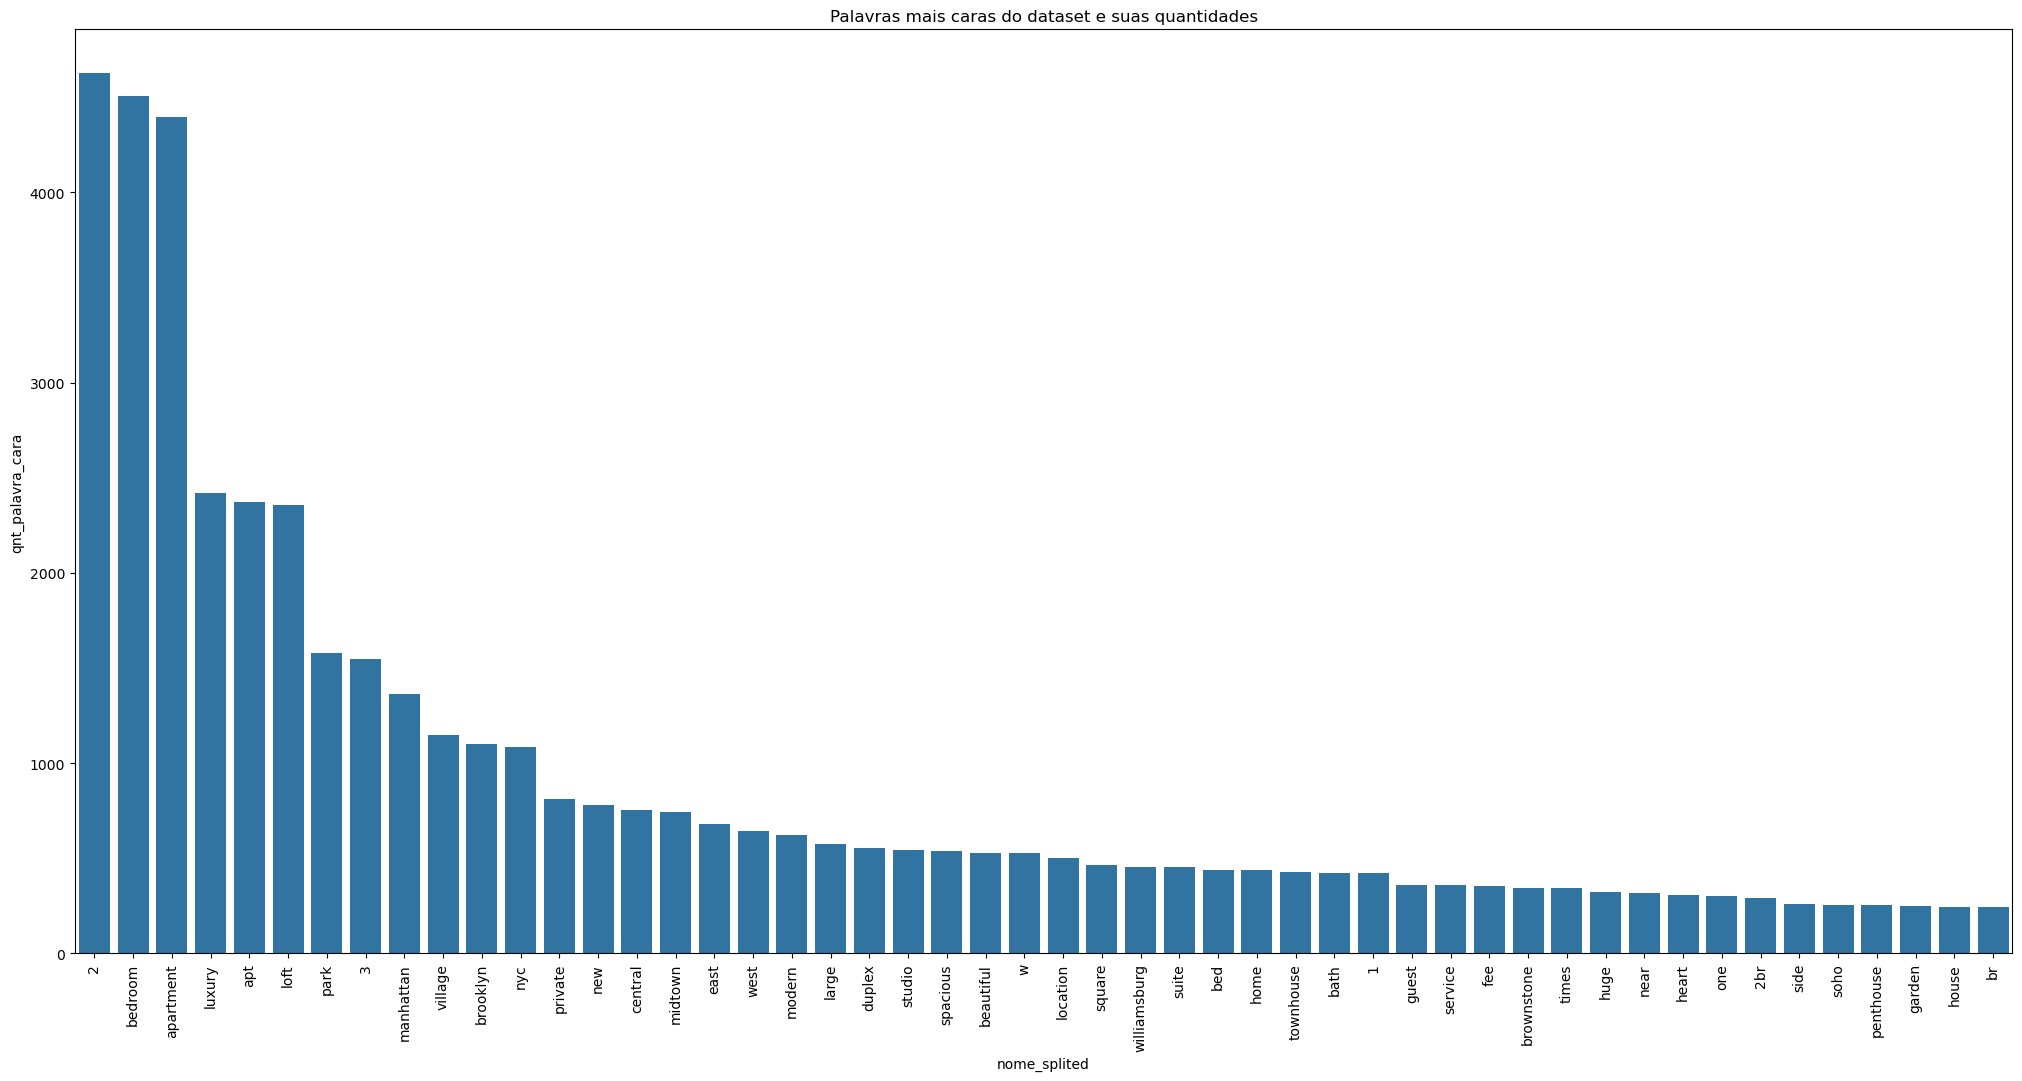

In [36]:
# Filtrando faixa de valores caros
expensive_words = df_words[(df_words['price'] >= 350)].sort_values('quantidade', ascending=False)
aux1 = expensive_words.loc[:, ['nome_splited', 'quantidade']].groupby('nome_splited').sum().sort_values('quantidade', ascending=False).reset_index()
aux1.columns = ['nome_splited', 'qnt_palavra_cara']

# Barplot palavras caras x quantidade 
ax = sns.barplot(data=aux1.head(50), x='nome_splited', y='qnt_palavra_cara')
plt.xticks(rotation=90)
ax.set_title('Palavras mais caras do dataset e suas quantidades')
plt.show()


Dentre as palavras mais caras que aparecem no gráfico acima, as 3 primeiras que fazem sentido são, bedroom, apartment e luxury. Apt também aparece como a mais cara, sendo o mesmo que apartment, que se somarem as quantidades delas, seria a palavra mais cara que apareceu mais vezes.